# init

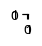

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dataframe_image as dfi
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS, get_aa_properties
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump, get_palette
from src.bootstrap import bootstrap_eval, get_pval, plot_pval
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
mpl.rcParams['figure.dpi'] = 180

# init

## reloading datasets

In [2]:
cedar_related = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_related = pd.read_csv('../data/mutant/221119_prime_related_10fold.csv')
ibel = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')
# merged = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')
nepdb = pd.read_csv('../data/mutant/230124_nepdb_filtered_scored.csv')
nepdb.head()

,Peptide,wild_type,HLA,agg_label,mut_len,wt_len,seq_id,Pos_mut,Peptide_mut,core_mut,...,core_blsm_mut_score,aliphatic_index,boman,hydrophobicity,isoelectric_point,VHSE1,VHSE3,VHSE7,VHSE8,trueHLA_EL_rank
0,AFGSAHLFR,AFGSAHLYR,HLA-A3101,1,9,9,seq_1,0,AFGSAHLFR,AFGSAHLFR,...,3,65.555556,0.837778,0.455556,10.551759,0.214444,-0.278889,0.193333,-0.192222,0.2470
1,AIANRIKFK,AIANRIKSK,HLA-A1101,0,9,9,seq_4,0,AIANRIKFK,AIANRIKFK,...,-2,108.888889,1.802222,-0.044444,11.823055,-0.048889,0.125556,0.484444,-0.125556,0.1380
2,AICKPLHYV,AICKPLHYM,HLA-A0201,0,9,9,seq_5,0,AICKPLHYV,AICKPLHYV,...,1,130.000000,-0.735556,0.755556,8.530526,0.327778,0.046667,-0.017778,0.263333,0.3610
3,AIPAMVVPNV,AIPAMVVPNA,HLA-A0201,0,10,10,seq_6,0,AIPAMVVPNV,AIPAVVPNV,...,0,146.000000,-1.637000,1.590000,6.100000,0.431000,-0.385000,-0.067000,0.446000,2.2606
4,ALEVLQSIPY,APEVLQSIPY,HLA-A0101,0,10,10,seq_7,0,ALEVLQSIPY,ALEVLQSIY,...,-3,156.000000,-0.472000,0.740000,3.849983,0.292000,-0.062000,-0.096000,0.088000,0.6230


In [3]:
cedar_expr = pd.read_csv('../data/pepx/230125_cedar_related_pepx_fold.csv')
prime_expr = pd.read_csv('../data/pepx/230125_prime_related_pepx.csv')
ibel_expr = pd.read_csv('../data/pepx/230125_ibel_normal_pepx.csv')
nepdb_expr = pd.read_csv('../data/pepx/230125_nepdb_normal_pepx.csv')

In [4]:
cedar_aligned = pd.read_csv('../data/aligned_icore/230308_cedar_aligned_icore.csv')
prime_aligned = pd.read_csv('../data/aligned_icore/230308_prime_aligned_icore.csv')
ibel_aligned = pd.read_csv('../data/aligned_icore/230308_ibel_aligned_icore.csv')
nepdb_aligned = pd.read_csv('../data/aligned_icore/230308_nepdb_aligned_icore.csv')

In [8]:
cedar_aligned_expr = pd.read_csv('../data/pepx/230418_cedar_aligned_pepx.csv')
prime_aligned_expr = pd.read_csv('../data/pepx/230418_prime_aligned_pepx.csv')
ibel_aligned_expr = pd.read_csv('../data/pepx/230125_ibel_aligned_pepx.csv')
nepdb_aligned_expr = pd.read_csv('../data/pepx/230418_nepdb_aligned_pepx.csv')

In [ ]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

# Redef data processing fct

In [34]:
cedar_aligned['len_core_mut'] = cedar_aligned['core_mut'].apply(len)
cedar_aligned.len_core_mut.unique()

array([9])

In [35]:
cedar_aligned['CoreNotAA'] = cedar_aligned['core_mut'].apply(lambda x: any([z not in AA_KEYS for z in x]))
cedar_aligned['n-'] = cedar_aligned['core_mut'].apply(lambda x: x.count('-'))
cedar_aligned['core_eq'] = cedar_aligned['core_wt_aligned']==cedar_aligned['core_mut']
cedar_aligned['icore_eq'] = cedar_aligned['icore_wt_aligned']==cedar_aligned['icore_mut']

In [49]:
cedar_aligned.groupby(['icore_eq', 'core_eq','CoreNotAA', 'len_icore_mut']).count()

HLA  agg_label  fold  Peptide  \
icore_eq core_eq CoreNotAA len_icore_mut                                   
False    False   False     9              2067       2067  2067     2067   
                           10              485        485   485      485   
                           11              207        207   207      207   
                           12                1          1     1        1   
                 True      8                99         99    99       99   
         True    False     10               29         29    29       29   
                           11               29         29    29       29   
True     True    False     9                79         79    79       79   
                           10               11         11    11       11   
                 True      8                26         26    26       26   

                                          wild_type  icore_mut  core_mut  \
icore_eq core_eq CoreNotAA len_icore_mut                                   
False    False   False     9                   2067       2067      2067   
                           10                   485        485       485   
                           11                   207        207       207   
                           12                     1          1         1   
                 True      8                     99         99        99   
         True    False     10                    29         29        29   
                           11                    29         29        29   
True     True    False     9                     79         79        79   
                           10                    11         11        11   
                 True      8                     26         26        26   

                                           len  EL_rank_mut  EL_rank_wt  ...  \
icore_eq core_eq CoreNotAA len_icore_mut                                 ...   
False    False   False     9              2067         2067        2067  ...   
                           10              485          485         485  ...   
                           11              207          207         207  ...   
                           12                1            1           1  ...   
                 True      8                99           99          99  ...   
         True    False     10               29           29          29  ...   
                           11               29           29          29  ...   
True     True    False     9                79           79          79  ...   
                           10               11           11          11  ...   
                 True      8                26           26          26  ...   

                                          isoelectric_point  VHSE1  VHSE3  \
icore_eq core_eq CoreNotAA len_icore_mut                                    
False    False   False     9                           2067   2067   2067   
                           10                           485    485    485   
                           11                           207    207    207   
                           12                             1      1      1   
                 True      8                             99     99     99   
         True    False     10                            29     29     29   
                           11                            29     29     29   
True     True    False     9                             79     79     79   
                           10                            11     11     11   
                 True      8                             26     26     26   

                                          VHSE7  VHSE8  seq_id  \
icore_eq core_eq CoreNotAA len_icore_mut                         
False    False   False     9               2067   2067    2067   
                           10               485    485     485   
                           11               207    207     207   
 

In [52]:
cedar_aligned.query('len_icore_mut>len_core_mut')[['HLA','agg_label','Peptide','icore_mut', 'core_mut', 
                                                   'wild_type','icore_wt_aligned','core_wt_aligned','icore_eq','core_eq']]

,HLA,agg_label,Peptide,icore_mut,core_mut,wild_type,icore_wt_aligned,core_wt_aligned,icore_eq,core_eq
5,HLA-B0702,0,AALHTPRPGPL,ALHTPRPGPL,ALHTPRPPL,AALHNPRPGPL,ALHNPRPGPL,ALHNPRPPL,False,False
13,HLA-A1101,0,AAYQRLTSEK,AAYQRLTSEK,AAYQLTSEK,AAYQQLTSEK,AAYQQLTSEK,AAYQQLTSK,False,False
20,HLA-B4403,0,AEVDQDGVVM,AEVDQDGVVM,AEVDQGVVM,AEVDEDGVVM,AEVDEDGVVM,AEVDEGVVM,False,False
22,HLA-A6801,0,AEWRNGSTSSL,EWRNGSTSSL,EWNGSTSSL,PEWRNGSTSSL,EWRNGSTSSL,EWNGSTSSL,True,True
23,HLA-A2402,0,AFLSTHLKLFL,AFLSTHLKLF,AFLSTHLLF,AFLSTHLKLFP,AFLSTHLKLF,AFLSTHLLF,True,True
...,...,...,...,...,...,...,...,...,...,...
3009,HLA-A0201,0,YVARGGSMGV,YVARGGSMGV,YVAGGSMGV,YVARGGPMGV,YVARGGPMGV,YVAGGPMGV,False,False
3010,HLA-A0201,0,YVEYYSWLSYL,YVEYYSWLSYL,YVYSWLSYL,YVEYYRWLSYL,YVEYYRWLSYL,YVYRWLSYL,False,False
3016,HLA-B0702,0,YVRRVFITDDL,YVRRVFITDDL,YVRRVFITL,YVRRVFITDDF,YVRRVFITDDF,YVRRVFITF,False,False
3018,HLA-A6801,0,YVSEKDVISAK,YVSEKDVISAK,YVSDVISAK,YVSEKDVTSAK,YVSEKDVTSAK,YVSDVTSAK,False,False


In [47]:
cedar_aligned.query('CoreNotAA')[['HLA','agg_label','Peptide','wild_type','icore_mut','icore_wt_aligned','icore_eq','core_mut','core_wt_aligned','core_eq']]

,HLA,agg_label,Peptide,wild_type,icore_mut,icore_wt_aligned,icore_eq,core_mut,core_wt_aligned,core_eq
39,HLA-A0201,0,AIYHTLNLFNI,AIYHTLNLCNI,AIYHTLNL,AIYHTLNL,True,AIY-HTLNL,AIY-HTLNL,True
40,HLA-B0702,0,AKNCGIAIPV,AKNRGIAIPV,AKNCGIAI,AKNRGIAI,False,-AKNCGIAI,-AKNRGIAI,False
105,HLA-B1501,0,ALSIGTSYRY,ALSIGTPYRY,ALSIGTSY,ALSIGTPY,False,ALS-IGTSY,ALS-IGTPY,False
133,HLA-A0201,0,AMYLNYFRGL,AMYLNYCRGL,YLNYFRGL,YLNYCRGL,False,YLN-YFRGL,YL-NYCRGL,False
158,HLA-B0702,0,APTWRALAR,APTWRALAG,APTWRALA,APTWRALA,True,APT-WRALA,APT-WRALA,True
...,...,...,...,...,...,...,...,...,...,...
2838,HLA-C1403,0,WYTHNLIFVF,WYTHNLFFVF,WYTHNLIF,WYTHNLFF,False,WYT-HNLIF,WYT-HNLFF,False
2869,HLA-A0201,1,YKLVVVGAV,YKLVVVGAG,KLVVVGAV,KLVVVGAG,False,KLV-VVGAV,KLVVVGAG-,False
2933,HLA-A1101,1,YMKSLEFENK,YMKSSEFENK,KSLEFENK,KSSEFENK,False,KSLE-FENK,KSSE-FENK,False
3013,HLA-A0201,0,YVMASVFVCPL,YVMASVFVCLL,YVMASVFV,YVMASVFV,True,YVMASVF-V,YVMASVF-V,True


In [ ]:
def get_core_dataset(df, ics_dict, max_len=9, encoding='onehot', blosum_matrix=BL62_VALUES,
                     seq_col='core_mut', hla_col='HLA', target_col='agg_label', rank_col='EL_rank_mut',
                     mut_col=None, mask=False, invert=False, add_rank=False, mask_aa=None):
    """
    """
    x, y = get_array_dataset(df, ics_dict, max_len, encoding, blosum_matrix, seq_col, hla_col, target_col, rank_col,
                             mask, invert, add_rank=add_rank, add_aaprop=add_aaprop, remove_pep=remove_pep)
    
    
    if mut_col is not None and type(mut_col) == list:
        if len(mut_col) > 0:
            mut_scores = df[mut_col].values
            x = np.concatenate([x, mut_scores], axis=1)
    if mask_aa:
        if mask_aa.lower() == 'false':
            return x, y
        assert mask_aa.upper() in AA_KEYS, f'Amino acid to mask is not in the AA alphabet!' \
                                           '\nYou provided {mask_aa}, and the alphabet is {AA_KEYS}'
        x[:, AA_KEYS.index(mask_aa.upper())] = 0
    return x, y

In [84]:
# Replacing the '-' with zeros so that we ignore that position but keep the ordering (needed for the IC weights to be on the right pos)
CHAR_TO_INT['-']=-1
INT_TO_CHAR[-1]='-'
seq='AIY-HTLNL'
int_encoded = [CHAR_TO_INT[x] for x in seq]
onehot_encoded = list()
for value in int_encoded:
    letter = [0 for _ in range(len(AA_KEYS))]
    letter[value] = 1 if value != -1 else 0
    onehot_encoded.append(letter)
tmp = np.array(onehot_encoded)
tmp[3,:]==0, tmp.shape == (9,20) # check that the position 3 is all 0 and array has the right shape

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True]),
 True)

In [314]:
import torch
def find_extra_aa(core, icore):
    assert len(core)==9, f'Core is not of length 9 somehow: {core}'
    if len(icore)==len(core) or len(icore)==8:
        return np.zeros((20))
    
    elif len(icore)>len(core):
        results = []
        j = 0
        for i, char in enumerate(icore):
            if char!=core[j]:
                results.append(char)
            else:
                j+=1
        return (encode(''.join(results)).sum(axis=0).numpy() / len(icore)).astype(np.float32)
    
def batch_find_extra_aa(core_seqs, icore_seqs):
    return np.stack(map(find_aa, core_seqs,icore_seqs)).astype(np.float32)

In [302]:
from src.data_processing import batch_compute_frequency, encode_batch_weighted, encode_batch, get_ic_weights, CHAR_TO_INT, INT_TO_CHAR, encode, get_ic_weights
# All 3 cases, where core with a '-', Icore > core, Icore==core
sample = pd.concat([cedar_aligned.query('CoreNotAA').sample(2, random_state=13), 
                    cedar_aligned.query('len_icore_mut>len_core_mut').sample(2, random_state=13),
                    cedar_aligned.query('len_icore_mut==len_core_mut').sample(2, random_state=13)])
core_seqs = sample['core_mut'].values
icore_seqs = sample['icore_mut'].values
core_seqs, icore_seqs, len(sample)

(array(['SVS-FGTVY', 'SYWNR-LQF', 'FLQEVNVGV', 'KMFKTTPPV', 'QLDIIPASV',
        'ITDAHELGV'], dtype=object),
 array(['SVSFGTVY', 'SYWNRLQF', 'FLQEVNVCGV', 'KMTNFKTTPPV', 'QLDIIPASV',
        'ITDAHELGV'], dtype=object),
 6)

In [306]:
encode_batch_weighted(sample, ics_shannon, None, 9, 'onehot', None, 'core_mut')

before 6 Int64Index([785, 1276, 527, 1216, 1852, 1044], dtype='int64')
after drop 6 Int64Index([785, 1276, 527, 1216, 1852, 1044], dtype='int64')


tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9169,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.3213],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9634,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9604, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0

In [315]:
weighted_sequences = encode_batch_weighted(sample, ics_dict=ics_shannon, max_len=9, encoding='onehot', blosum_matrix=None, seq_col='core_mut')
# Here added a special argument "true_lens" where we provide the true lengths
freqs = batch_compute_frequency(weighted_sequences.numpy(), true_lens=9)
extra_freqs = batch_find_extra_aa(core_seqs, icore_seqs)
summed = np.add(freqs,extra_freqs)
summed[4:]

before 6 Int64Index([785, 1276, 527, 1216, 1852, 1044], dtype='int64')
after drop 6 Int64Index([785, 1276, 527, 1216, 1852, 1044], dtype='int64')
xd!! 6


array([[0.10369743, 0.        , 0.        , 0.10237203, 0.        ,
        0.09803756, 0.        , 0.        , 0.        , 0.19956324,
        0.0370485 , 0.        , 0.        , 0.        , 0.09752864,
        0.10269237, 0.        , 0.        , 0.        , 0.04814585],
       [0.10457226, 0.        , 0.        , 0.08788767, 0.        ,
        0.        , 0.10608057, 0.10462533, 0.10660405, 0.10613236,
        0.10538305, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.07088175, 0.        , 0.        , 0.01572936]],
      dtype=float32)

In [325]:
x,y = get_dataset(sample, ics_shannon, max_len=9, encoding='onehot', blosum_matrix=None, seq_col='core_mut', hla_col='HLA', target_col='agg_label',
                  rank_col='EL_rank_mut', mask=False, invert=False, add_rank=True, add_aaprop=False, remove_pep=False, icore_bulge=True,
                  core_col='core_mut', icore_col='icore_mut')

True
here
before 6 Int64Index([785, 1276, 527, 1216, 1852, 1044], dtype='int64')
after drop 6 Int64Index([785, 1276, 527, 1216, 1852, 1044], dtype='int64')
xd!! 6


# Training a model with only rank and all weightings

In [341]:

encoding_kwargs = dict(max_len=9, encoding='onehot', blosum_matrix=None, mask=False, add_rank=True,
                       add_aaprop=False, remove_pep=False, standardize=True, seq_col='core_mut',
                       icore_bulge=True, core_col='core_mut', icore_col='icore_mut')
encoding_kwargs.pop('standardize')
x,y=get_dataset(sample, ics_shannon, **encoding_kwargs)
(x[:,:20]==summed).all()

True

In [419]:
sample

,HLA,agg_label,fold,Peptide,wild_type,icore_mut,core_mut,len,EL_rank_mut,EL_rank_wt,...,VHSE8,seq_id,core_wt_aligned,EL_rank_wt_aligned,len_core_mut,CoreNotAA,n-,core_eq,icore_eq,icore_eq_core
785,HLA-C1403,0,7,GSVSFGTVY,GSGSFGTVY,SVSFGTVY,SVS-FGTVY,9,2.4606,3.7812,...,-0.188750,>seq_786,SGS-FGTVY,3.7812,9,True,1,False,False,False
1276,HLA-A2402,0,5,KSYWNRLQF,KSYWNRLRF,SYWNRLQF,SYWNR-LQF,9,0.2599,0.3379,...,-0.307500,>seq_1277,SYW-NRLRF,0.3379,9,True,1,False,False,False
527,HLA-A0203,1,8,FLQEVNVCGV,FLQEVNVYGV,FLQEVNVCGV,FLQEVNVGV,10,0.3130,0.2390,...,-0.363000,>seq_528,FLQEVNVYV,0.2390,9,False,0,False,False,False
1216,HLA-A0201,0,3,KMTNFKTTPPV,KMTDFKTTPPV,KMTNFKTTPPV,KMFKTTPPV,11,1.9568,0.9945,...,0.621818,>seq_1217,KMTDFTPPV,0.9945,9,False,0,False,False,False
1852,HLA-A0201,1,9,QLDIIPASV,QLDIIPASI,QLDIIPASV,QLDIIPASV,9,0.1110,0.4652,...,0.270000,>seq_1853,QLDIIPASI,0.4652,9,False,0,False,False,True
1044,HLA-A0101,0,8,ITDAHELGVA,ITAAHELGVA,ITDAHELGV,ITDAHELGV,10,0.3941,5.1050,...,-0.108889,>seq_1045,ITAAHELGV,5.1050,9,False,0,False,False,True


In [423]:
a,b = encode_batch_weighted(sample, ics_dict=ics_shannon, max_len=9, seq_col='core_mut')
a.shape, b.shape

(torch.Size([6, 9, 20]), (6, 9))

In [427]:
def x(a,b):
    return a+b
def f(a):
    return a, 2*a

x(*f(2))

6

In [389]:
from src.utils import mkdirs
from sklearn.ensemble import RandomForestClassifier
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
outdir = '../output/230314_bulgeOut_aligned/'
mkdirs(outdir)
mkdirs(f'{outdir}raw/')
mkdirs(f'{outdir}bootstrapping/')

train_dataset = cedar_aligned
cedar_dataset = cedar_aligned
prime_dataset = prime_aligned
nepdb_dataset = nepdb_aligned


def final_bootstrap_wrapper(preds_df, filename, ic_name, icore_bulge, key, evalset,
                            n_rounds=10000, n_jobs=36):
    scores = preds_df.pred.values if 'pred' in preds_df.columns else preds_df['mean_pred'].values
    targets = preds_df.agg_label.values if 'agg_label' in preds_df.columns else preds_df['Immunogenicity'].values

    bootstrapped_df, mean_rocs = bootstrap_eval(y_score=scores,
                                                y_true=targets,
                                                n_rounds=n_rounds, n_jobs=n_jobs)
    bootstrapped_df['encoding'] = 'onehot'
    bootstrapped_df['bulgeOut'] = icore_bulge
    bootstrapped_df['weight'] = ic_name
    bootstrapped_df['pep_col'] = 'core_mut'
    bootstrapped_df['rank_col'] = 'EL_rank_mut'
    bootstrapped_df['key'] = key
    bootstrapped_df['evalset'] = evalset.upper()

    bootstrapped_df.to_csv(
        f'{outdir}bootstrapping/{evalset}_bootstrapped_df_{filename}.csv',
        index=False)
    pkl_dump(mean_rocs,
             f'{outdir}bootstrapping/{evalset}_mean_rocs_{filename}.pkl')

    return bootstrapped_df

encoding_kwargs = dict(max_len=9, encoding='onehot', blosum_matrix=None, mask=False, add_rank=True,
                       add_aaprop=False, remove_pep=False, standardize=True, seq_col='core_mut', rank_col='EL_rank_mut',
                       icore_bulge=True, core_col='core_mut', icore_col='icore_mut')

mega_df = pd.DataFrame()

print(encoding_kwargs['icore_bulge'])
for invert in [True, False]:
    for ic_name, ics_dict in tqdm(
            zip(['Mask', 'KL', 'None', 'Shannon'], [ics_shannon, ics_kl, None, ics_shannon]),
            desc='Weighting', leave=False, position=2):
        # Set args
        encoding_kwargs['invert'] = invert
        encoding_kwargs['mask'] = True if 'Mask' in ic_name else False
        # Load params
        if invert:
            if ic_name == 'None':
                continue
            else:
                ic_name = 'Inverted ' + ic_name

        filename = f'onehot_{"-".join(ic_name.split(" "))}_bulgeOut{encoding_kwargs["icore_bulge"]}_rank_only'
        # Using the same model and hyperparameters
        model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                       max_depth=8, ccp_alpha=9.945e-6)
        # Training model and getting feature importances
        print('Training', encoding_kwargs)
        trained_models, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model,
                                                                    ics_dict=ics_dict,
                                                                    encoding_kwargs=encoding_kwargs,
                                                                    n_jobs=8)
        fi = get_nested_feature_importance(trained_models)
        fn = AA_KEYS + ['rank']
        df_fi = pd.DataFrame(fi, index=fn).T
        df_fi.to_csv(f'{outdir}raw/featimps_{filename}.csv', index=False)

        for evalset, evalname in zip([cedar_dataset, prime_dataset, nepdb_dataset],
                                                     ['CEDAR', 'PRIME', 'NEPDB']):
            # FULLY FILTERED + Mean_pred
            if not evalset.equals(train_dataset):
                evalset = evalset.query('Peptide not in @train_dataset.Peptide.values')
            _, preds = evaluate_trained_models_sklearn(evalset.drop_duplicates(subset=['Peptide','HLA','agg_label']),
                                                       trained_models, ics_dict,
                                                       train_dataset,
                                                       encoding_kwargs, concatenated=False,
                                                       only_concat=False)
            # p_col = 'pred' if 'pred' in preds.columns else 'mean_pred'
            preds.to_csv(
                f'{outdir}raw/{evalname}_preds_{filename}.csv', index=False)

            bootstrapped_df = final_bootstrap_wrapper(preds, filename, ic_name, encoding_kwargs['icore_bulge'],
                                                      'only_rank', evalname, n_rounds=10000,
                                                      n_jobs=8)
            mega_df = mega_df.append(bootstrapped_df)
mega_df.to_csv(f'{outdir}/total_df.csv', index=False)


True


Weighting: 0it [00:00, ?it/s]

Training {'max_len': 9, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': True, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'core_mut', 'rank_col': 'EL_rank_mut', 'icore_bulge': True, 'core_col': 'core_mut', 'icore_col': 'icore_mut', 'invert': True}


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/CEDAR_mean_rocs_onehot_Inverted-Mask_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/PRIME_mean_rocs_onehot_Inverted-Mask_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/NEPDB_mean_rocs_onehot_Inverted-Mask_bulgeOutTrue_rank_only.pkl saved.
Training {'max_len': 9, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'core_mut', 'rank_col': 'EL_rank_mut', 'icore_bulge': True, 'core_col': 'core_mut', 'icore_col': 'icore_mut', 'invert': True}


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/CEDAR_mean_rocs_onehot_Inverted-KL_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/PRIME_mean_rocs_onehot_Inverted-KL_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/NEPDB_mean_rocs_onehot_Inverted-KL_bulgeOutTrue_rank_only.pkl saved.
Training {'max_len': 9, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'core_mut', 'rank_col': 'EL_rank_mut', 'icore_bulge': True, 'core_col': 'core_mut', 'icore_col': 'icore_mut', 'invert': True}


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/CEDAR_mean_rocs_onehot_Inverted-Shannon_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/PRIME_mean_rocs_onehot_Inverted-Shannon_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/NEPDB_mean_rocs_onehot_Inverted-Shannon_bulgeOutTrue_rank_only.pkl saved.


Weighting: 0it [00:00, ?it/s]

Training {'max_len': 9, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': True, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'core_mut', 'rank_col': 'EL_rank_mut', 'icore_bulge': True, 'core_col': 'core_mut', 'icore_col': 'icore_mut', 'invert': False}


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/CEDAR_mean_rocs_onehot_Mask_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/PRIME_mean_rocs_onehot_Mask_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/NEPDB_mean_rocs_onehot_Mask_bulgeOutTrue_rank_only.pkl saved.
Training {'max_len': 9, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'core_mut', 'rank_col': 'EL_rank_mut', 'icore_bulge': True, 'core_col': 'core_mut', 'icore_col': 'icore_mut', 'invert': False}


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/CEDAR_mean_rocs_onehot_KL_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/PRIME_mean_rocs_onehot_KL_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/NEPDB_mean_rocs_onehot_KL_bulgeOutTrue_rank_only.pkl saved.
Training {'max_len': 9, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'core_mut', 'rank_col': 'EL_rank_mut', 'icore_bulge': True, 'core_col': 'core_mut', 'icore_col': 'icore_mut', 'invert': False}


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/CEDAR_mean_rocs_onehot_None_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/PRIME_mean_rocs_onehot_None_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/NEPDB_mean_rocs_onehot_None_bulgeOutTrue_rank_only.pkl saved.
Training {'max_len': 9, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'core_mut', 'rank_col': 'EL_rank_mut', 'icore_bulge': True, 'core_col': 'core_mut', 'icore_col': 'icore_mut', 'invert': False}


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/CEDAR_mean_rocs_onehot_Shannon_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/PRIME_mean_rocs_onehot_Shannon_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/NEPDB_mean_rocs_onehot_Shannon_bulgeOutTrue_rank_only.pkl saved.


In [477]:
def find_extra_aa(core, icore):
    """
    Finds the bulging out AA between an icore and its corresponding core, returning the extra AA as "frequencies"
    Args:
        core:
        icore:

    Returns:

    """
    assert len(core) == 9, f'Core is not of length 9 somehow: {core}'
    if len(icore) == len(core) or len(icore) == 8:
        return np.zeros((20))

    elif len(icore) > len(core):
        results = []
        j = 0
        for i, char in enumerate(icore):
            if char != core[j]:
                results.append(char)
            else:
                j += 1
        # Here changed to len icore - len core to get len of bulge
        # return (encode(''.join(results)).sum(axis=0).numpy() / (len(icore)-len(core))).astype(np.float32)

        # Here, changed to return the extra + the length so that we can do the weighted division
        return encode(''.join(results)).sum(axis=0).numpy(), np.array(len(icore)-len(core))

def batch_find_extra_aa(core_seqs, icore_seqs):
    """
    Same as above but by batch
    Args:
        core_seqs:
        icore_seqs:

    Returns:

    """
    mapped = list(map(find_extra_aa, core_seqs, icore_seqs))
    encoded, lens = np.array([x[0] for x in mapped]), np.array([x[1] for x in mapped])
    return encoded, lens
x,w = encode_batch_weighted(sample, ics_shannon, 'cpu', 9, seq_col='core_mut', return_weights=True)
extra_freqs, extra_lens = batch_find_extra_aa(sample['core_mut'].values, sample['icore_mut'].values)

In [ ]:
extra_lens

array([0., 0., 1., 2., 0., 0.])

In [ ]:
x.sum(axis=1)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9563, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.9604, 0.0000, 1.8803, 0.9475, 0.0000,
         0.4945, 1.2588],
        [0.0000, 0.9615, 0.9423, 0.0000, 0.0000, 0.9364, 0.0000, 0.0000, 0.0000,
         0.0000, 0.9621, 0.0000, 0.0000, 0.4905, 0.0000, 0.9403, 0.0000, 0.9483,
         0.3512, 0.0000],
        [0.0000, 0.0000, 0.8612, 0.0000, 0.0000, 0.9371, 0.8460, 0.9149, 0.0000,
         0.0000, 0.3467, 0.0000, 0.0000, 0.8795, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 2.3462],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.7204, 0.3334, 0.9213, 1.8575, 0.0000, 1.8357, 0.0000,
         0.0000, 0.4333],
        [0.9333, 0.0000, 0.0000, 0.9213, 0.0000, 0.8823, 0.0000, 0.0000, 0.0000,
         1.7961, 0.3334, 0.0000, 0.0000, 0.0000, 0.8778, 0.9242, 0.0000, 0.0000,
         0.0000, 0.4333],
        [0.9412, 0.0000, 0.0000, 0.7910, 0.0000, 0.0000, 0.9

In [519]:
weights = w.mean(axis=2).sum(axis=1) + extra_lens

In [ ]:
batch_compute_frequency(x, np.repeat(weights0))

RuntimeError: The size of tensor a (6) must match the size of tensor b (2) at non-singleton dimension 0

In [553]:
from src.utils import mkdirs
from sklearn.ensemble import RandomForestClassifier
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn

# Rerun but here in the code I changed the find_extra_aa to divide by the length of the 
# bulge rather than by the length of the entire icore
outdir = '../output/230320_bulgeOut_aligned_divideByWeights/'
mkdirs(outdir)
mkdirs(f'{outdir}raw/')
mkdirs(f'{outdir}bootstrapping/')

train_dataset = cedar_aligned
cedar_dataset = cedar_aligned
prime_dataset = prime_aligned
nepdb_dataset = nepdb_aligned


def final_bootstrap_wrapper(preds_df, filename, ic_name, icore_bulge, key, evalset,
                            n_rounds=10000, n_jobs=36):
    scores = preds_df.pred.values if 'pred' in preds_df.columns else preds_df['mean_pred'].values
    targets = preds_df.agg_label.values if 'agg_label' in preds_df.columns else preds_df['Immunogenicity'].values

    bootstrapped_df, mean_rocs = bootstrap_eval(y_score=scores,
                                                y_true=targets,
                                                n_rounds=n_rounds, n_jobs=n_jobs)
    bootstrapped_df['encoding'] = 'onehot'
    bootstrapped_df['bulgeOut'] = icore_bulge
    bootstrapped_df['weight'] = ic_name
    bootstrapped_df['pep_col'] = 'core_mut'
    bootstrapped_df['rank_col'] = 'EL_rank_mut'
    bootstrapped_df['key'] = key
    bootstrapped_df['evalset'] = evalset.upper()

    bootstrapped_df.to_csv(
        f'{outdir}bootstrapping/{evalset}_bootstrapped_df_{filename}.csv',
        index=False)
    pkl_dump(mean_rocs,
             f'{outdir}bootstrapping/{evalset}_mean_rocs_{filename}.pkl')

    return bootstrapped_df

encoding_kwargs = dict(max_len=9, encoding='onehot', blosum_matrix=None, mask=False, add_rank=True,
                       add_aaprop=False, remove_pep=False, standardize=True, seq_col='core_mut', rank_col='EL_rank_mut',
                       icore_bulge=True, core_col='core_mut', icore_col='icore_mut')

mega_df = pd.DataFrame()

print(encoding_kwargs['icore_bulge'])
for invert in [True, False]:
    for ic_name, ics_dict in tqdm(
            zip(['Mask', 'KL', 'None', 'Shannon'], [ics_shannon, ics_kl, None, ics_shannon]),
            desc='Weighting', leave=False, position=2):
        # Set args
        encoding_kwargs['invert'] = invert
        encoding_kwargs['mask'] = True if 'Mask' in ic_name else False
        # Load params
        if invert:
            if ic_name == 'None':
                continue
            else:
                ic_name = 'Inverted ' + ic_name

        filename = f'onehot_{"-".join(ic_name.split(" "))}_bulgeOut{encoding_kwargs["icore_bulge"]}_rank_only'
        # Using the same model and hyperparameters
        model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                       max_depth=8, ccp_alpha=9.945e-6)
        # Training model and getting feature importances
        print('Training', encoding_kwargs)
        trained_models, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model,
                                                                    ics_dict=ics_dict,
                                                                    encoding_kwargs=encoding_kwargs,
                                                                    n_jobs=8)
        fi = get_nested_feature_importance(trained_models)
        fn = AA_KEYS + ['rank']
        df_fi = pd.DataFrame(fi, index=fn).T
        df_fi.to_csv(f'{outdir}raw/featimps_{filename}.csv', index=False)

        for evalset, evalname in zip([cedar_dataset, prime_dataset, nepdb_dataset],
                                                     ['CEDAR', 'PRIME', 'NEPDB']):
            # FULLY FILTERED + Mean_pred
            if not evalset.equals(train_dataset):
                evalset = evalset.query('Peptide not in @train_dataset.Peptide.values')
            _, preds = evaluate_trained_models_sklearn(evalset.drop_duplicates(subset=['Peptide','HLA','agg_label']),
                                                       trained_models, ics_dict,
                                                       train_dataset,
                                                       encoding_kwargs, concatenated=False,
                                                       only_concat=False)
            # p_col = 'pred' if 'pred' in preds.columns else 'mean_pred'
            preds.to_csv(
                f'{outdir}raw/{evalname}_preds_{filename}.csv', index=False)

            bootstrapped_df = final_bootstrap_wrapper(preds, filename, ic_name, encoding_kwargs['icore_bulge'],
                                                      'only_rank', evalname, n_rounds=10000,
                                                      n_jobs=8)
            mega_df = mega_df.append(bootstrapped_df)
mega_df.to_csv(f'{outdir}/total_df.csv', index=False)


True


Weighting: 0it [00:00, ?it/s]

Training {'max_len': 9, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': True, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'core_mut', 'rank_col': 'EL_rank_mut', 'icore_bulge': True, 'core_col': 'core_mut', 'icore_col': 'icore_mut', 'invert': True}


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/CEDAR_mean_rocs_onehot_Inverted-Mask_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/PRIME_mean_rocs_onehot_Inverted-Mask_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/NEPDB_mean_rocs_onehot_Inverted-Mask_bulgeOutTrue_rank_only.pkl saved.
Training {'max_len': 9, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'core_mut', 'rank_col': 'EL_rank_mut', 'icore_bulge': True, 'core_col': 'core_mut', 'icore_col': 'icore_mut', 'invert': True}


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/CEDAR_mean_rocs_onehot_Inverted-KL_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/PRIME_mean_rocs_onehot_Inverted-KL_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/NEPDB_mean_rocs_onehot_Inverted-KL_bulgeOutTrue_rank_only.pkl saved.
Training {'max_len': 9, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'core_mut', 'rank_col': 'EL_rank_mut', 'icore_bulge': True, 'core_col': 'core_mut', 'icore_col': 'icore_mut', 'invert': True}


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/CEDAR_mean_rocs_onehot_Inverted-Shannon_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/PRIME_mean_rocs_onehot_Inverted-Shannon_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/NEPDB_mean_rocs_onehot_Inverted-Shannon_bulgeOutTrue_rank_only.pkl saved.


Weighting: 0it [00:00, ?it/s]

Training {'max_len': 9, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': True, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'core_mut', 'rank_col': 'EL_rank_mut', 'icore_bulge': True, 'core_col': 'core_mut', 'icore_col': 'icore_mut', 'invert': False}


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/CEDAR_mean_rocs_onehot_Mask_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/PRIME_mean_rocs_onehot_Mask_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/NEPDB_mean_rocs_onehot_Mask_bulgeOutTrue_rank_only.pkl saved.
Training {'max_len': 9, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'core_mut', 'rank_col': 'EL_rank_mut', 'icore_bulge': True, 'core_col': 'core_mut', 'icore_col': 'icore_mut', 'invert': False}


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/CEDAR_mean_rocs_onehot_KL_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/PRIME_mean_rocs_onehot_KL_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/NEPDB_mean_rocs_onehot_KL_bulgeOutTrue_rank_only.pkl saved.
Training {'max_len': 9, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'core_mut', 'rank_col': 'EL_rank_mut', 'icore_bulge': True, 'core_col': 'core_mut', 'icore_col': 'icore_mut', 'invert': False}


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/CEDAR_mean_rocs_onehot_None_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/PRIME_mean_rocs_onehot_None_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/NEPDB_mean_rocs_onehot_None_bulgeOutTrue_rank_only.pkl saved.
Training {'max_len': 9, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'core_mut', 'rank_col': 'EL_rank_mut', 'icore_bulge': True, 'core_col': 'core_mut', 'icore_col': 'icore_mut', 'invert': False}


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/CEDAR_mean_rocs_onehot_Shannon_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/PRIME_mean_rocs_onehot_Shannon_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/NEPDB_mean_rocs_onehot_Shannon_bulgeOutTrue_rank_only.pkl saved.


# Results

Should compare the results between core+bulge out, vs ICORE (like normal aligned from before using only rank)

see 230125_aligned_icore_mutscore + query for "only rank"

In [9]:
mega_icore_df = pd.read_csv('../output/230125_aligned_icore_mutscore/total_df.csv').query('key=="only_rank" and encoding=="onehot"')

In [10]:
total_df_old_div = pd.read_csv('../output/230314_bulgeOut_aligned/total_df.csv').rename(columns={'bulgeOut':'AA_bulge'})
total_df_old_div['AA_bulge'] = 'old_div'

total_df_new_div = pd.read_csv('../output/230314_bulgeOut_aligned_diffDivision/total_df.csv').rename(columns={'bulgeOut':'AA_bulge'})
total_df_new_div['AA_bulge'] = 'new_div'

total_df_divweight = pd.read_csv('../output/230320_bulgeOut_aligned_dividebyweights/total_df.csv').rename(columns={'bulgeOut':'AA_bulge'})
total_df_divweight['AA_bulge'] = 'div_by_summedWeight'

In [11]:
mega_icore_df = mega_icore_df.query('evalset!="IBEL"')
mega_icore_df['AA_bulge']= 'None'

In [12]:
concat=pd.concat([mega_icore_df, total_df_old_div, total_df_new_div, total_df_divweight])
gb_list = []
for evalset in concat.evalset.unique():
    tmp = concat.query('evalset==@evalset')
    tmp = tmp.groupby(['weight', 'pep_col', 'AA_bulge']).agg(mean_auc=('auc','mean'), mean_auc01=('auc_01', 'mean'), mean_AP=('AP', 'mean'))
    tmp.columns = [f'{x}_{evalset}' for x in tmp.columns]
    gb_list.append(tmp)
gb_merged = pd.concat(gb_list, axis=1)

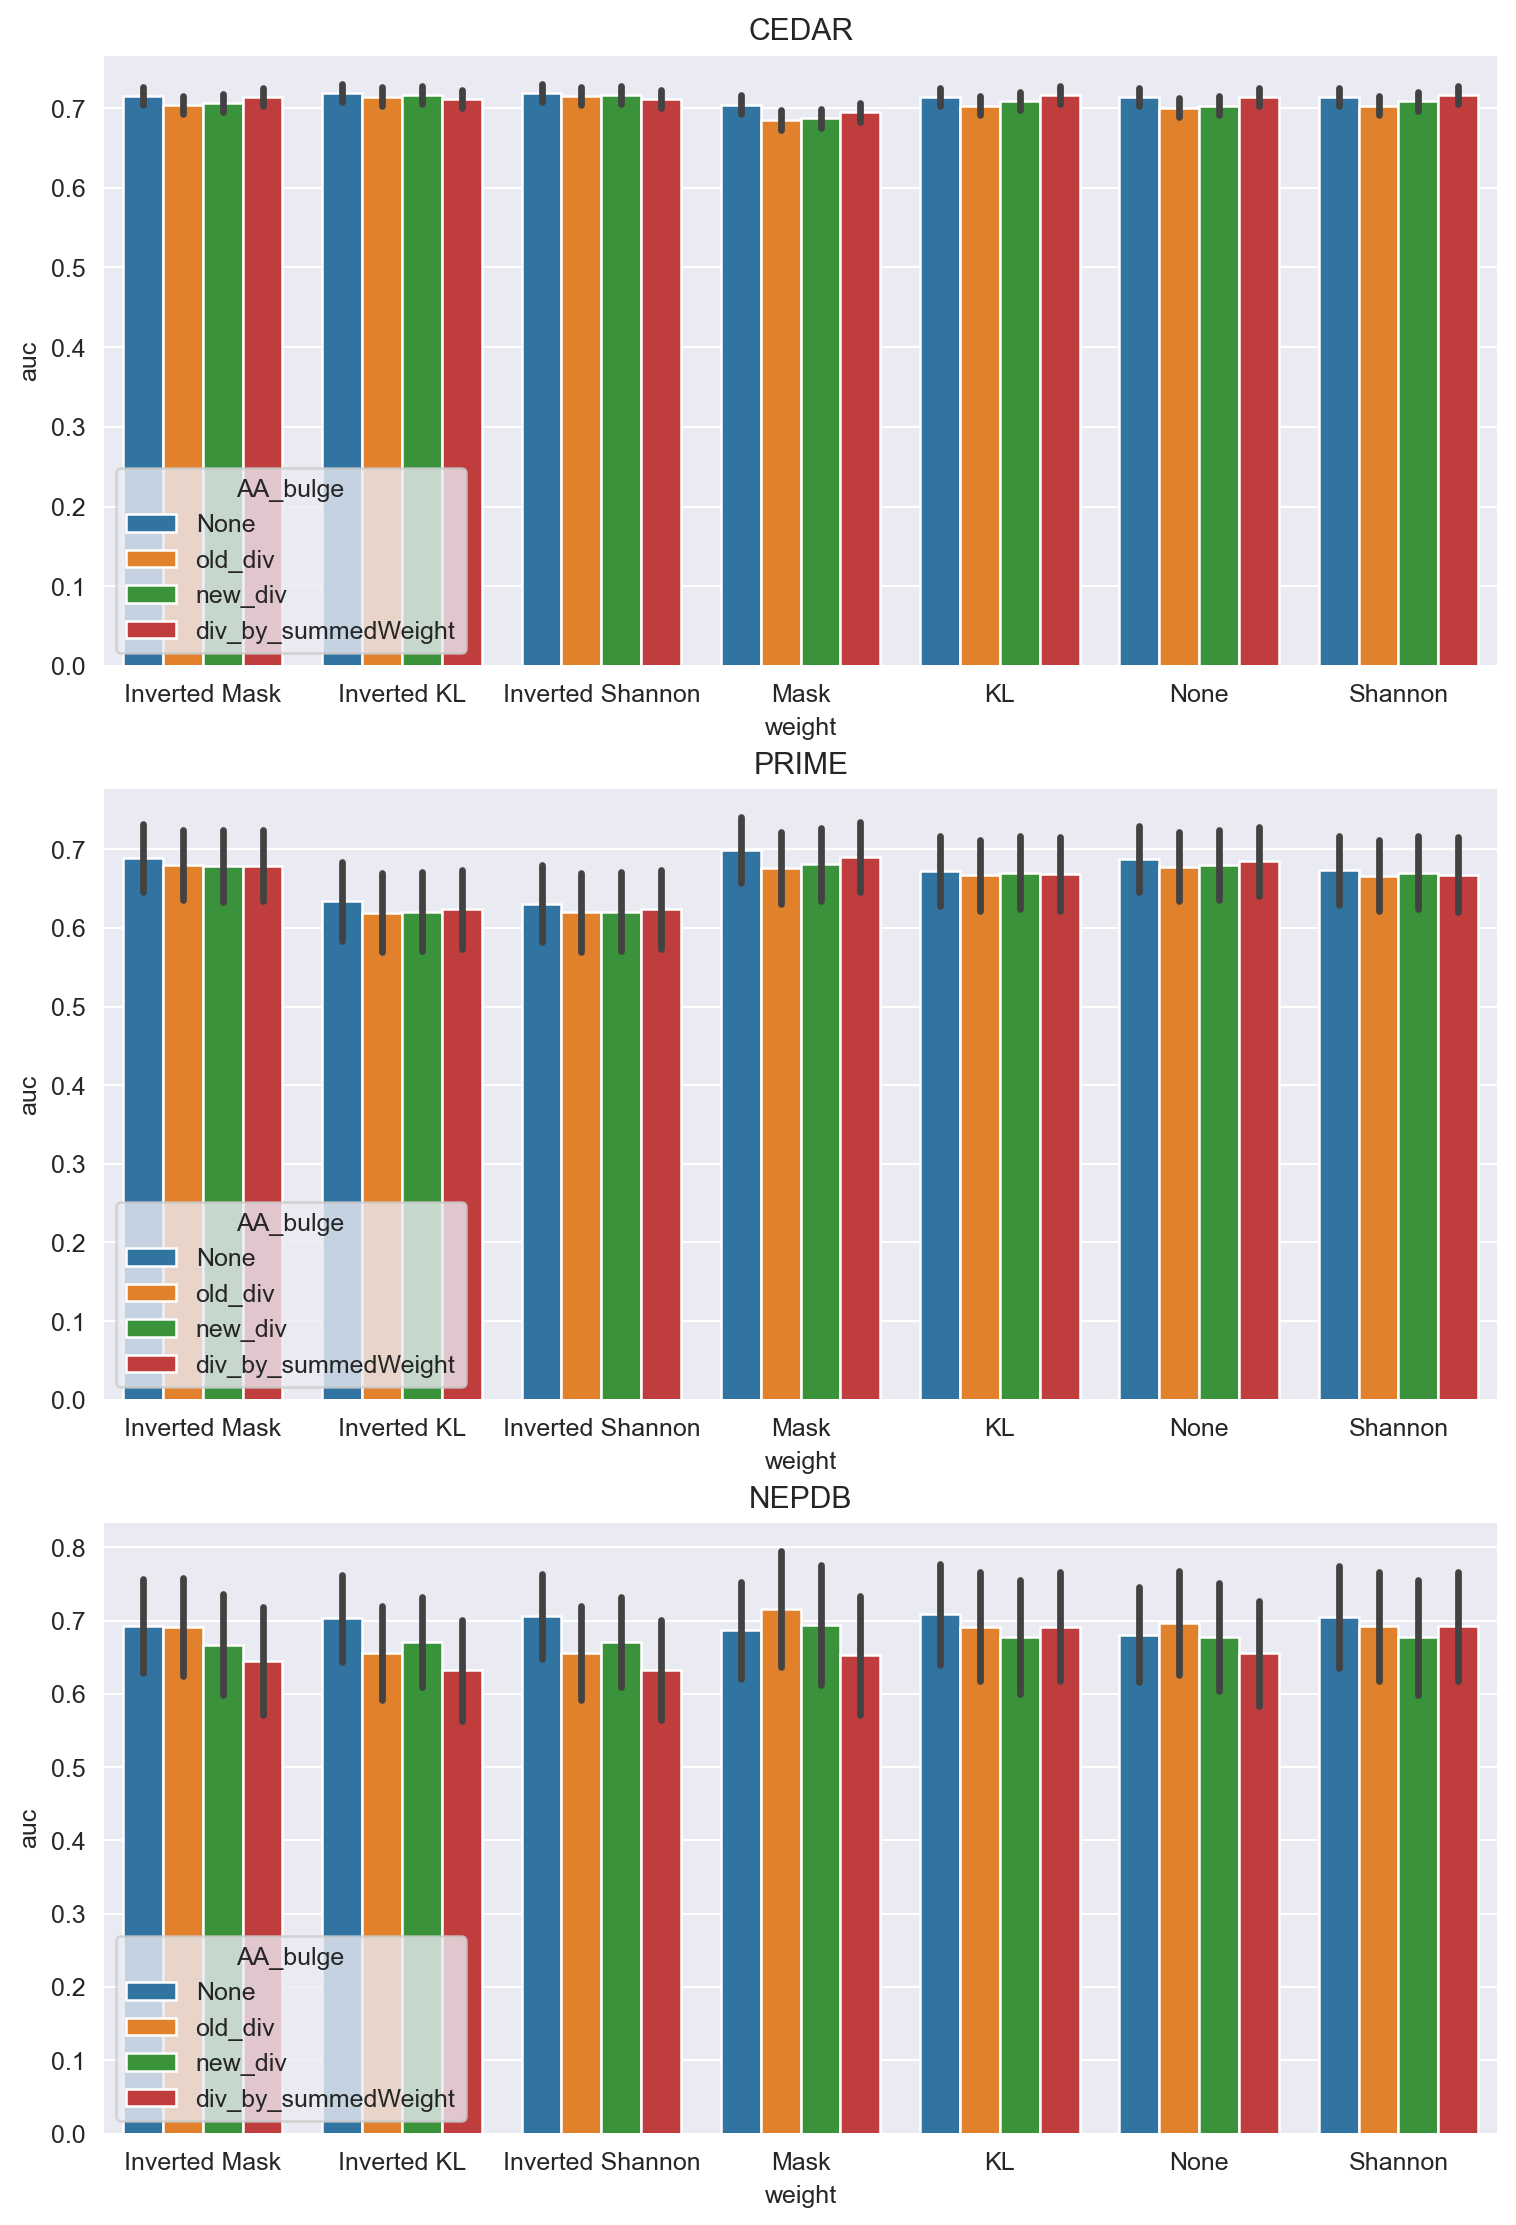

In [13]:
f,a = plt.subplots(3,1,figsize=(10,15))
for i, evalset in enumerate(concat.evalset.unique()):
    sns.barplot(data=concat.query('evalset==@evalset'), x='weight', y='auc', hue='AA_bulge', ax=a[i], errorbar='sd')
    a[i].set_title(evalset)

In [403]:
sample

,HLA,agg_label,fold,Peptide,wild_type,icore_mut,core_mut,len,EL_rank_mut,EL_rank_wt,...,VHSE8,seq_id,core_wt_aligned,EL_rank_wt_aligned,len_core_mut,CoreNotAA,n-,core_eq,icore_eq,icore_eq_core
785,HLA-C1403,0,7,GSVSFGTVY,GSGSFGTVY,SVSFGTVY,SVS-FGTVY,9,2.4606,3.7812,...,-0.188750,>seq_786,SGS-FGTVY,3.7812,9,True,1,False,False,False
1276,HLA-A2402,0,5,KSYWNRLQF,KSYWNRLRF,SYWNRLQF,SYWNR-LQF,9,0.2599,0.3379,...,-0.307500,>seq_1277,SYW-NRLRF,0.3379,9,True,1,False,False,False
527,HLA-A0203,1,8,FLQEVNVCGV,FLQEVNVYGV,FLQEVNVCGV,FLQEVNVGV,10,0.3130,0.2390,...,-0.363000,>seq_528,FLQEVNVYV,0.2390,9,False,0,False,False,False
1216,HLA-A0201,0,3,KMTNFKTTPPV,KMTDFKTTPPV,KMTNFKTTPPV,KMFKTTPPV,11,1.9568,0.9945,...,0.621818,>seq_1217,KMTDFTPPV,0.9945,9,False,0,False,False,False
1852,HLA-A0201,1,9,QLDIIPASV,QLDIIPASI,QLDIIPASV,QLDIIPASV,9,0.1110,0.4652,...,0.270000,>seq_1853,QLDIIPASI,0.4652,9,False,0,False,False,True
1044,HLA-A0101,0,8,ITDAHELGVA,ITAAHELGVA,ITDAHELGV,ITDAHELGV,10,0.3941,5.1050,...,-0.108889,>seq_1045,ITAAHELGV,5.1050,9,False,0,False,False,True


# 230417 RE-RE-REdefine icore/pep input stuff

## redef mixed inputs

In [14]:
def improved_binder(rank_mut, rank_wt):
    if rank_mut / rank_wt >= 1:
        return False
    else:
        if rank_mut>2.0:
            return False
        else:
            if rank_wt/rank_mut >= 2:
                return True
            else:
                return False
cedar_aligned_expr['impr_icore'] = cedar_aligned_expr.apply(lambda x: improved_binder(x['EL_rank_mut'],x['EL_rank_wt_aligned']), axis=1)
cedar_aligned_expr['impr_pep'] = cedar_aligned_expr.apply(lambda x: improved_binder(x['trueHLA_EL_rank'],x['EL_rank_wt']), axis=1)

In [15]:
len(cedar_aligned_expr.query('impr_icore')), len(cedar_aligned_expr.query('impr_icore and not impr_pep')), len(cedar_aligned_expr.query('not impr_icore and impr_pep')), len(cedar_aligned_expr.query('impr_pep'))

(962, 202, 0, 760)

In [16]:
cedar_aligned_expr.query('impr_icore and not impr_pep')[['Peptide','wild_type', 'icore_mut', 'icore_wt_aligned', 'trueHLA_EL_rank', 'EL_rank_mut', 'EL_rank_wt', 'EL_rank_wt_aligned']]

,Peptide,wild_type,icore_mut,icore_wt_aligned,trueHLA_EL_rank,EL_rank_mut,EL_rank_wt,EL_rank_wt_aligned
33,AILPFTPEFL,AISPFTPEFL,ILPFTPEFL,ISPFTPEFL,0.7790,0.5632,1.4141,9.3854
34,AILPFTPEFLV,AISPFTPEFLV,ILPFTPEFL,ISPFTPEFL,0.6360,0.5632,1.0875,9.3854
53,ALAQKGVQLGL,ALARKGVQLGL,ALAQKGVQL,ALARKGVQL,1.0357,0.2014,0.4706,0.4706
72,ALFTWTNLLV,AVFTWTNLLV,ALFTWTNLL,AVFTWTNLL,0.7175,0.1260,0.8968,0.8968
73,ALFTWTNLLVV,AVFTWTNLLVV,ALFTWTNLL,AVFTWTNLL,1.2620,0.1260,0.4466,0.8968
...,...,...,...,...,...,...,...,...
2891,YMMMWDCWHAV,YMMMRDCWHAV,MMWDCWHAV,MMRDCWHAV,1.1053,0.1711,1.1135,1.5896
2909,YPPPPPALL,YPPPPPALP,YPPPPPALL,YPPPPPALP,0.0508,0.0508,0.0810,1.2088
2929,YSFQSLLYLL,YPFQSLLYLL,YSFQSLLYL,YPFQSLLYL,6.4067,1.1039,4.1224,4.1224
2931,YSFQSLLYLLL,YPFQSLLYLLL,YSFQSLLYL,YPFQSLLYL,8.3788,1.1039,1.7104,4.1224


In [17]:
ics_len = pkl_load('../data/ic_dicts/ics_len.pkl')
ics_len.keys()
def get_len(row, t=0.25):
    # print(row)
    l = len(row['icore_mut'])
    hla = row['HLA']
    return ics_len[l][hla][t]
cedar_aligned_expr['ic_len'] = cedar_aligned_expr.apply(get_len,axis=1)
cedar_aligned_expr.query('ic_len<=200')[['Peptide','icore_mut', 'agg_label','HLA','len','len_icore_mut', 'ic_len', 'trueHLA_EL_rank','EL_rank_mut']].groupby(['len_icore_mut','HLA']).count()

Peptide  icore_mut  agg_label  len  ic_len  \
len_icore_mut HLA                                                     
8             HLA-A0206        2          2          2    2       2   
              HLA-A1101        4          4          4    4       4   
              HLA-A6801        2          2          2    2       2   
              HLA-A6802        1          1          1    1       1   

                         trueHLA_EL_rank  EL_rank_mut  
len_icore_mut HLA                                      
8             HLA-A0206                2            2  
              HLA-A1101                4            4  
              HLA-A6801                2            2  
              HLA-A6802                1            1

In [18]:
prime_aligned_expr['ic_len'] = prime_aligned_expr.apply(get_len,axis=1)

prime_aligned_expr.query('ic_len<=200')[['Peptide','icore_mut', 'agg_label','HLA','len','len_icore_mut', 'ic_len', 'trueHLA_EL_rank','EL_rank_mut']].groupby(['len_icore_mut','HLA']).count()

Peptide  icore_mut  agg_label  len  ic_len  \
len_icore_mut HLA                                                     
8             HLA-A0206        1          1          1    1       1   
              HLA-A1101       15         15         15   15      15   
              HLA-A6801        8          8          8    8       8   
              HLA-A6802        2          2          2    2       2   
              HLA-A6901        1          1          1    1       1   

                         trueHLA_EL_rank  EL_rank_mut  
len_icore_mut HLA                                      
8             HLA-A0206                1            1  
              HLA-A1101               15           15  
              HLA-A6801                8            8  
              HLA-A6802                2            2  
              HLA-A6901                1            1

In [19]:
from copy import deepcopy
def formula(pep, ic):
    return (pep-ic) / (0.5*(pep+ic))

def get_icore_improves(row, threshold, improve_must_bind=False):
    """
    It's only better if the ICORE is also an improved binder,
    
    Here, fullpep vs icore rank should be:
    
    (pep_rank - icore_rank) / (0.5 * (pep_rank+icore_rank))
    """
    rank_icore = row['EL_rank_mut']
    rank_full = row['trueHLA_EL_rank']
    len_icore = row['len_icore_mut']
    pep = row['Peptide']
    icore = row['icore_mut']
    comparison = row['fullpep_vs_icore_rank']
    # If the same anyways, just return the mixed inputs
    if pep==icore or rank_icore>rank_full:
        return False, pep, rank_full
    # If rank IC is better than rank full:
    elif rank_icore<rank_full:
        if rank_icore>2 and improve_must_bind:
            return False, pep, rank_full
        else: 
            # If the improvement is above the threshold, return the icore
            if comparison>threshold:
                return True, icore, rank_icore
            # Else, just keep the peptide
            else:
                return False, pep, rank_full

cedar_aligned = pd.read_csv('../data/aligned_icore/230308_cedar_aligned_icore.csv')
prime_aligned = pd.read_csv('../data/aligned_icore/230308_prime_aligned_icore.csv')

checkcols=['Peptide','icore_mut', 'len','len_icore_mut', 'HLA','agg_label', 'trueHLA_EL_rank', 'EL_rank_mut', 'fullpep_vs_icore_rank']
checkcols2 = deepcopy(checkcols)
cedar_aligned['fullpep_vs_icore_rank']= cedar_aligned.apply(lambda x: formula(x['trueHLA_EL_rank'],x['EL_rank_mut']), axis=1)
prime_aligned['fullpep_vs_icore_rank']= prime_aligned.apply(lambda x: formula(x['trueHLA_EL_rank'],x['EL_rank_mut']), axis=1)

for t in [0.1, 0.25, 0.5, .75, 1]:
    cedar_aligned[[f'icore_improves_{t}'.replace('.','_'), 
                   f'mixed_input_{t}'.replace('.','_'), 
                   f'mixed_rank_{t}'.replace('.','_')]] = cedar_aligned.apply(get_icore_improves, threshold=t, improve_must_bind=False, axis=1, result_type='expand')
    prime_aligned[[f'icore_improves_{t}'.replace('.','_'), 
                   f'mixed_input_{t}'.replace('.','_'), 
                   f'mixed_rank_{t}'.replace('.','_')]] = prime_aligned.apply(get_icore_improves, threshold=t, improve_must_bind=False, axis=1, result_type='expand')
    checkcols2.extend([f'icore_improves_{t}'.replace('.','_'), f'mixed_input_{t}'.replace('.','_'), f'mixed_rank_{t}'.replace('.','_')])
    
    cedar_aligned[[f'icore_improves_binder_{t}'.replace('.','_'), 
                   f'mixed_input_binder_{t}'.replace('.','_'), 
                   f'mixed_rank_binder_{t}'.replace('.','_')]] = cedar_aligned.apply(get_icore_improves, threshold=t, improve_must_bind=True, axis=1, result_type='expand')
    prime_aligned[[f'icore_improves_binder_{t}'.replace('.','_'), 
                   f'mixed_input_binder_{t}'.replace('.','_'), 
                   f'mixed_rank_binder_{t}'.replace('.','_')]] = prime_aligned.apply(get_icore_improves, threshold=t, improve_must_bind=True, axis=1, result_type='expand')
    

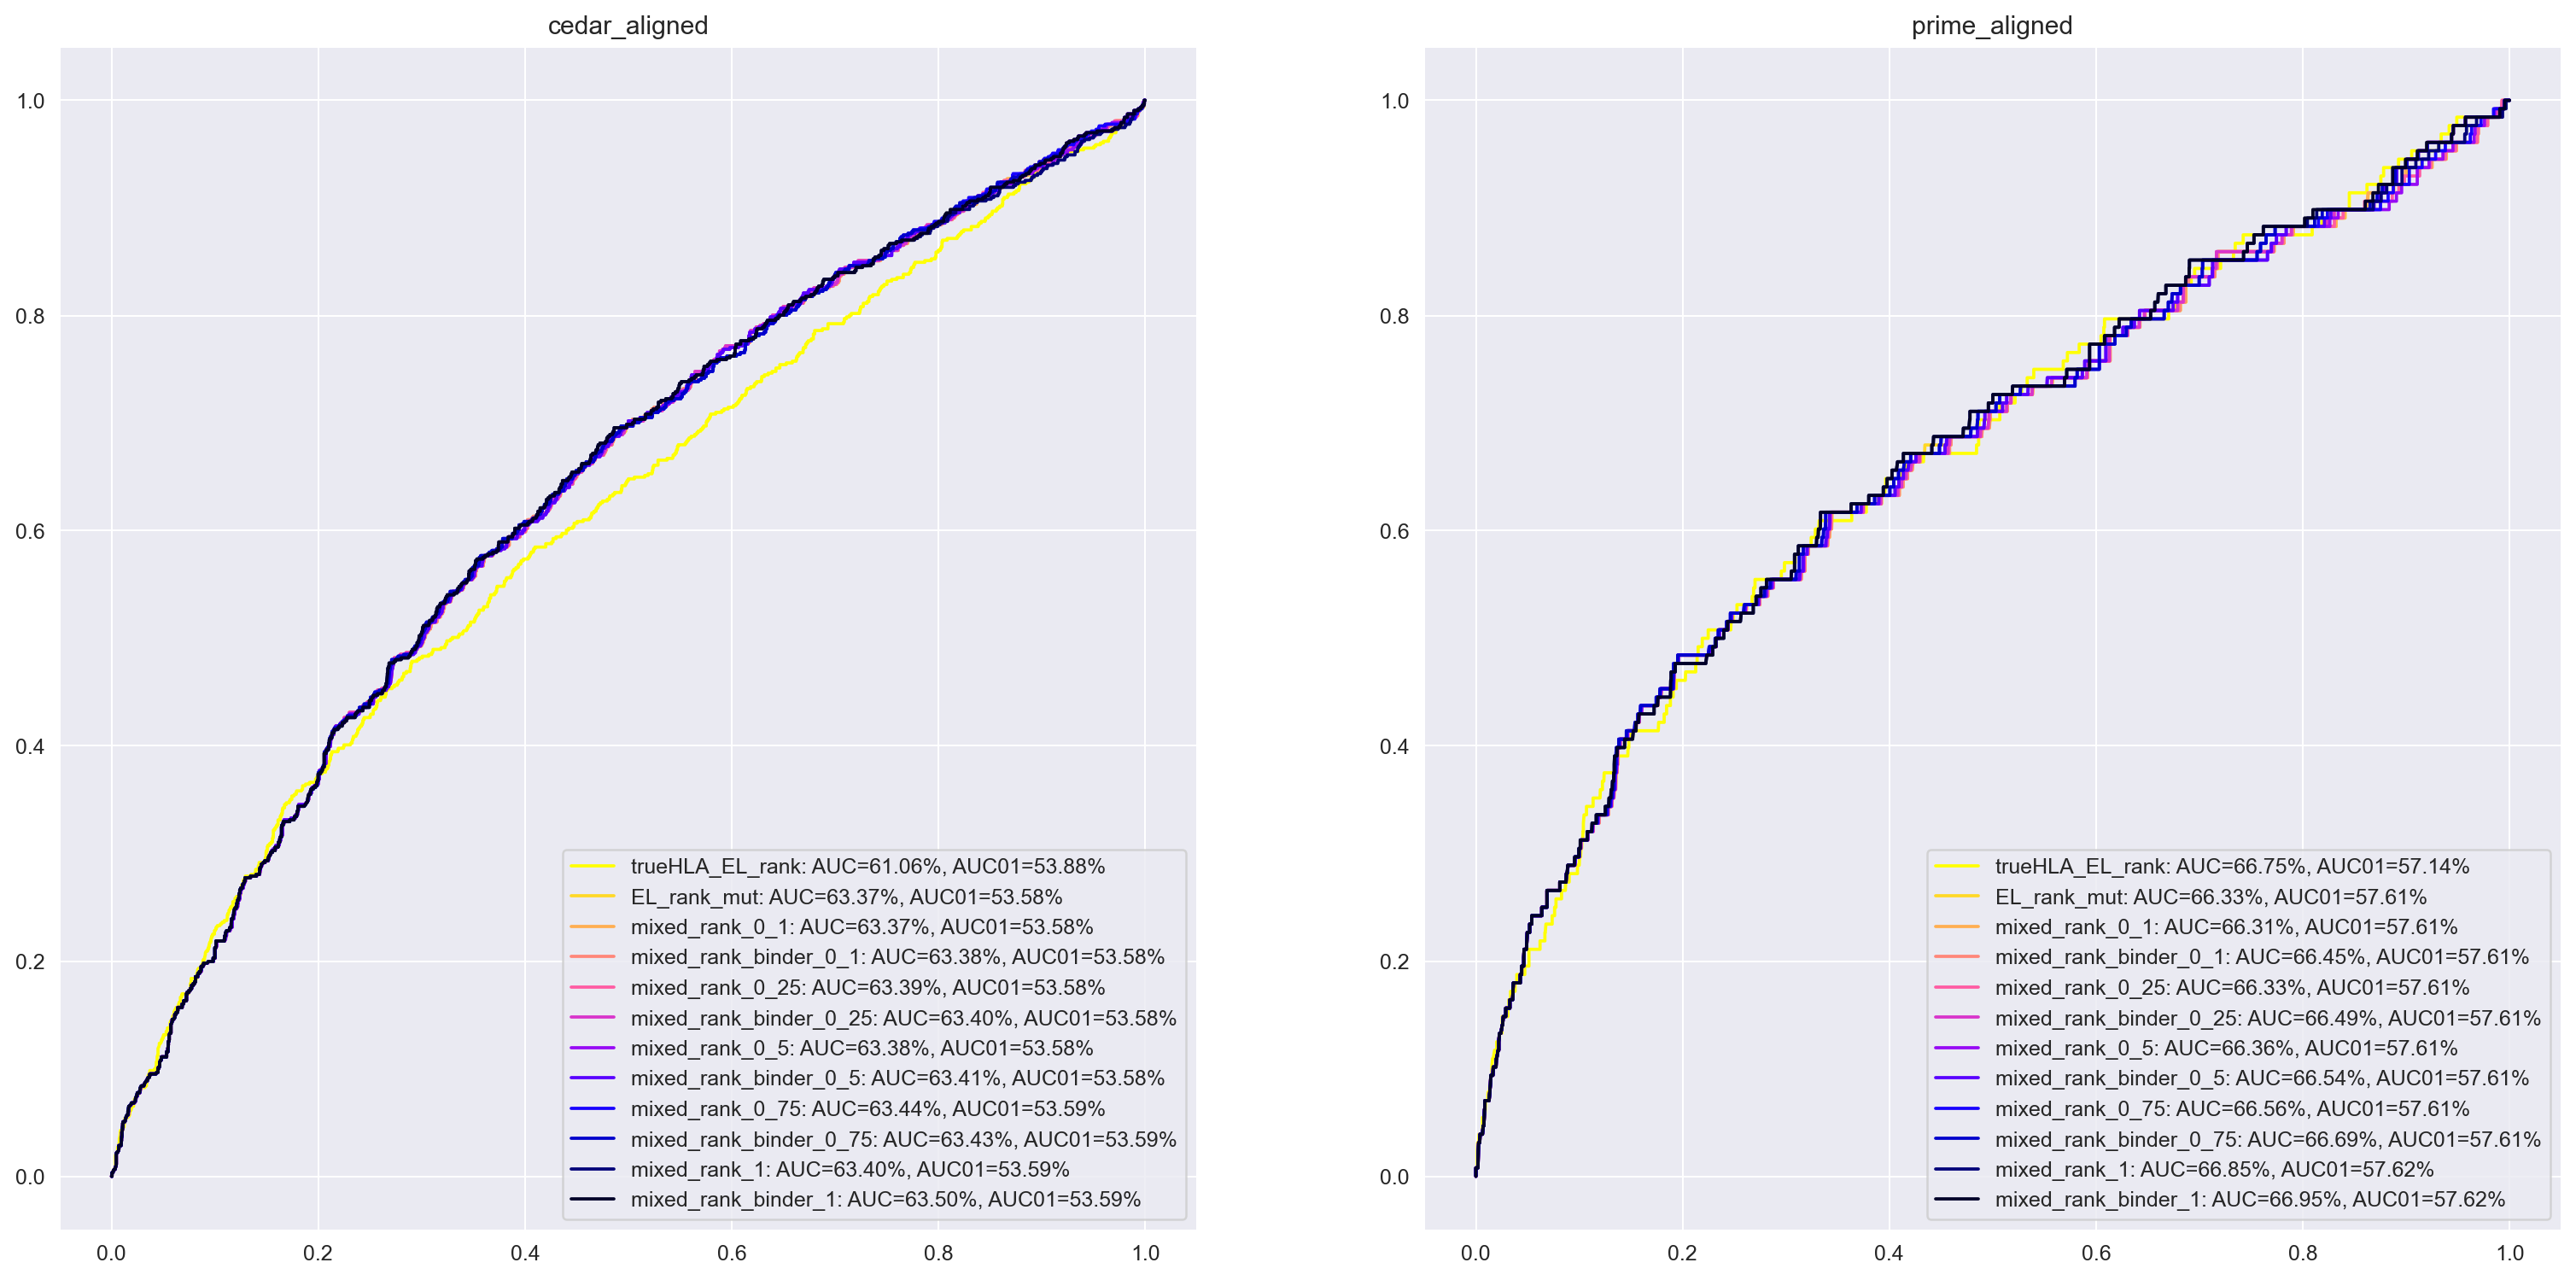

In [22]:
from sklearn.metrics import roc_curve ,roc_auc_score
f,a = plt.subplots(1,2, figsize=(21,10))
rankcols = ['trueHLA_EL_rank', 'EL_rank_mut']+[x for x in cedar_aligned.columns if x.startswith('mixed_rank_')]
sns.set_palette(get_palette('gnuplot2_r', len(rankcols)))
for rank in rankcols:
    labels = cedar_aligned['agg_label'].values
    scores = cedar_aligned[rank].values
    fpr, tpr, _ = roc_curve(labels, 1-scores)
    auc, auc01 = roc_auc_score(labels, 1-scores), roc_auc_score(labels, 1-scores, max_fpr=0.1)
    sns.lineplot(x=fpr, y=tpr, label=f'{rank}: AUC={auc:.2%}, AUC01={auc01:.2%}', estimator=None, ax=a[0])
    a[0].set_title('cedar_aligned')
    labels = prime_aligned['agg_label'].values
    scores = prime_aligned[rank].values
    fpr, tpr, _ = roc_curve(labels, 1-scores)
    auc, auc01 = roc_auc_score(labels, 1-scores), roc_auc_score(labels, 1-scores, max_fpr=0.1)
    sns.lineplot(x=fpr, y=tpr, label=f'{rank}: AUC={auc:.2%}, AUC01={auc01:.2%}', estimator=None, ax=a[1])
    a[1].set_title('prime_aligned')

In [23]:
rankcols = ['trueHLA_EL_rank', 'EL_rank_mut']+[x for x in cedar_aligned.columns if x.startswith('mixed_rank_')]
rankcols

['trueHLA_EL_rank',
 'EL_rank_mut',
 'mixed_rank_0_1',
 'mixed_rank_binder_0_1',
 'mixed_rank_0_25',
 'mixed_rank_binder_0_25',
 'mixed_rank_0_5',
 'mixed_rank_binder_0_5',
 'mixed_rank_0_75',
 'mixed_rank_binder_0_75',
 'mixed_rank_1',
 'mixed_rank_binder_1']

## Redo fig 3 and train models with the mixed inputs + the 8mer expanded core input

In [26]:
def get_expanded_input(row):
    input_col = row['core_mut'] if row['len_icore_mut']==8 else row['icore_mut']
    return input_col
cedar_aligned['expanded_input'] = cedar_aligned.apply(get_expanded_input,axis=1)
prime_aligned['expanded_input'] = prime_aligned.apply(get_expanded_input,axis=1)
nepdb_aligned['expanded_input'] = nepdb_aligned.apply(get_expanded_input,axis=1)

cedar_aligned.query('expanded_input.str.contains("-")')

,Unnamed: 0.1,Unnamed: 0,HLA,agg_label,fold,Peptide,wild_type,icore_mut,core_mut,len,...,icore_improves_binder_0_75,mixed_input_binder_0_75,mixed_rank_binder_0_75,icore_improves_1,mixed_input_1,mixed_rank_1,icore_improves_binder_1,mixed_input_binder_1,mixed_rank_binder_1,expanded_input
39,39,39,HLA-A0201,0,9,AIYHTLNLFNI,AIYHTLNLCNI,AIYHTLNL,AIY-HTLNL,11,...,False,AIYHTLNLFNI,5.8573,False,AIYHTLNLFNI,5.8573,False,AIYHTLNLFNI,5.8573,AIY-HTLNL
40,40,40,HLA-B0702,0,7,AKNCGIAIPV,AKNRGIAIPV,AKNCGIAI,-AKNCGIAI,10,...,False,AKNCGIAIPV,52.6923,False,AKNCGIAIPV,52.6923,False,AKNCGIAIPV,52.6923,-AKNCGIAI
105,105,105,HLA-B1501,0,5,ALSIGTSYRY,ALSIGTPYRY,ALSIGTSY,ALS-IGTSY,10,...,False,ALSIGTSYRY,0.4303,False,ALSIGTSYRY,0.4303,False,ALSIGTSYRY,0.4303,ALS-IGTSY
133,133,133,HLA-A0201,0,9,AMYLNYFRGL,AMYLNYCRGL,YLNYFRGL,YLN-YFRGL,10,...,False,AMYLNYFRGL,6.1562,False,AMYLNYFRGL,6.1562,False,AMYLNYFRGL,6.1562,YLN-YFRGL
158,158,158,HLA-B0702,0,4,APTWRALAR,APTWRALAG,APTWRALA,APT-WRALA,9,...,False,APTWRALAR,2.6840,False,APTWRALAR,2.6840,False,APTWRALAR,2.6840,APT-WRALA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2838,2838,2838,HLA-C1403,0,4,WYTHNLIFVF,WYTHNLFFVF,WYTHNLIF,WYT-HNLIF,10,...,True,WYTHNLIF,0.5629,True,WYTHNLIF,0.5629,True,WYTHNLIF,0.5629,WYT-HNLIF
2869,2869,2869,HLA-A0201,1,4,YKLVVVGAV,YKLVVVGAG,KLVVVGAV,KLV-VVGAV,9,...,False,YKLVVVGAV,27.7097,True,KLVVVGAV,7.6549,False,YKLVVVGAV,27.7097,KLV-VVGAV
2933,2933,2933,HLA-A1101,1,6,YMKSLEFENK,YMKSSEFENK,KSLEFENK,KSLE-FENK,10,...,False,YMKSLEFENK,3.9487,False,YMKSLEFENK,3.9487,False,YMKSLEFENK,3.9487,KSLE-FENK
3013,3013,3013,HLA-A0201,0,3,YVMASVFVCPL,YVMASVFVCLL,YVMASVFV,YVMASVF-V,11,...,False,YVMASVFVCPL,3.6690,False,YVMASVFVCPL,3.6690,False,YVMASVFVCPL,3.6690,YVMASVF-V


In [27]:
from sklearn.ensemble import RandomForestClassifier
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn

# Redo the base conditions
encoding_kwargs = {'max_len': 12, 'encoding': 'onehot', 'blosum_matrix': 'None', 'add_rank': True, 
                   'target_col': 'agg_label', 'hla_col': 'HLA', 'add_aaprop': False, 'remove_pep': False,
                   'mask': False, 'invert': False,'standardize':True} 
odir = '../output/230415_exprscore_analysis_FINAL/icore_pep_detour/'
bdfs = []
for ic_name, ics_dict, mask, invert in [('Inverted Shannon', ics_shannon, False, True),
                                        ('Inverted Mask', ics_shannon, True, True),
                                        ('None', None, False, False),
                                        ('Mask', ics_shannon, True, False),
                                        ('Shannon', ics_shannon, False, False)]:
    
    for seq, rank in zip(['Peptide', 'icore_mut'],['trueHLA_EL_rank','EL_rank_mut']):
        encoding_kwargs['seq_col'] = seq
        encoding_kwargs['rank_col'] = rank
        encoding_kwargs['mask']=mask
        encoding_kwargs['invert']=invert
        encoding_kwargs['standardize'] = True
        model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                                   max_depth=8, ccp_alpha=9.945e-6)
        # Training model and getting feature importances
        print('Training')
        trained_models, _, _ = nested_kcv_train_sklearn(cedar_aligned, model,
                                                        ics_dict=ics_dict,
                                                        encoding_kwargs=encoding_kwargs,
                                                        n_jobs=8)
        for evalset, evalname in zip([cedar_aligned, prime_aligned],['CEDAR','PRIME']):
            _, kcv_preds = evaluate_trained_models_sklearn(evalset,
                                                        trained_models, ics_dict,
                                                        cedar_aligned,
                                                        encoding_kwargs, concatenated=False,
                                                        only_concat=True, n_jobs=8)
            p_col = 'pred' if 'pred' in kcv_preds.columns else 'mean_pred'
            bdf = bootstrap_eval(kcv_preds[p_col], kcv_preds['agg_label'], n_rounds=10000, n_jobs=8, add_roc=False)
            bdf['input_type'] = encoding_kwargs['seq_col']
            bdf['weight'] = ic_name
            bdf['evalset']=evalname
            bdfs.append(bdf)
            del bdf, kcv_preds
        del trained_models
df_input_comp = pd.concat(bdfs)
del bdfs
# input_totaldf.to_csv('../output/230415_exprscore_analysis_FINAL/bootstrapped_dfs_new_inputs.csv')


Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


In [28]:
from sklearn.ensemble import RandomForestClassifier
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn

encoding_kwargs = {'max_len': 12, 'encoding': 'onehot', 'blosum_matrix': 'None', 'add_rank': True, 
                   'target_col': 'agg_label', 'hla_col': 'HLA', 'add_aaprop': False, 'remove_pep': False,
                   'mask': False, 'invert': False,'standardize':True} 
odir = '../output/230415_exprscore_analysis_FINAL/icore_pep_detour/'
bdfs = []
for ic_name, ics_dict, mask, invert in [('Inverted Shannon', ics_shannon, False, True),
                                        ('Inverted Mask', ics_shannon, True, True),
                                        ('None', None, False, False),
                                        ('Mask', ics_shannon, True, False),
                                        ('Shannon', ics_shannon, False, False)]:
    
    for t in [0.25, .5, .75, 1]:
        for binder in [True, False]:
            if t==0.25 and binder:
                continue
            if binder:
                encoding_kwargs['seq_col'] = f'mixed_input_binder_{t}'.replace('.','_')
                encoding_kwargs['rank_col'] = f'mixed_rank_binder_{t}'.replace('.','_')
            else:
                encoding_kwargs['seq_col'] = f'mixed_input_{t}'.replace('.','_')
                encoding_kwargs['rank_col'] = f'mixed_rank_{t}'.replace('.','_')
            encoding_kwargs['mask']=mask
            encoding_kwargs['invert']=invert
            encoding_kwargs['standardize'] = True
            model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                                       max_depth=8, ccp_alpha=9.945e-6)
            # Training model and getting feature importances
            print('Training')
            trained_models, _, _ = nested_kcv_train_sklearn(cedar_aligned, model,
                                                            ics_dict=ics_dict,
                                                            encoding_kwargs=encoding_kwargs,
                                                            n_jobs=8)
            for evalset, evalname in zip([cedar_aligned, prime_aligned],['CEDAR','PRIME']):
                _, kcv_preds = evaluate_trained_models_sklearn(evalset,
                                                            trained_models, ics_dict,
                                                            cedar_aligned,
                                                            encoding_kwargs, concatenated=False,
                                                            only_concat=True, n_jobs=8)
                p_col = 'pred' if 'pred' in kcv_preds.columns else 'mean_pred'
                bdf = bootstrap_eval(kcv_preds[p_col], kcv_preds['agg_label'], n_rounds=10000, n_jobs=8, add_roc=False)
                bdf['input_type'] = encoding_kwargs['seq_col']
                bdf['weight'] = ic_name
                bdf['evalset']=evalname
                bdfs.append(bdf)
                del bdf, kcv_preds
            del trained_models
input_totaldf = pd.concat(bdfs)
del bdfs
# input_totaldf.to_csv('../output/230415_exprscore_analysis_FINAL/bootstrapped_dfs_new_inputs.csv')


Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


In [29]:
concat=pd.concat([df_input_comp,
                  input_totaldf]).query('not weight.str.contains("KL")')
concat.to_csv('../output/230415_exprscore_analysis_FINAL/bootstrapped_dfs_new_inputs.csv')
concat.groupby(['evalset', 'weight', 'input_type']).agg(mean_auc=('auc','mean'),
                                                    mean_auc01=('auc_01','mean'))


mean_auc  mean_auc01
evalset weight        input_type                                   
CEDAR   Inverted Mask Peptide                  0.689963    0.566262
                      icore_mut                0.715081    0.580782
                      mixed_input_0_25         0.715056    0.581488
                      mixed_input_0_5          0.714020    0.582813
                      mixed_input_0_75         0.713306    0.581628
...                                                 ...         ...
PRIME   Shannon       mixed_input_0_75         0.676142    0.563862
                      mixed_input_1            0.677188    0.562370
                      mixed_input_binder_0_5   0.668191    0.560954
                      mixed_input_binder_0_75  0.674823    0.560140
                      mixed_input_binder_1     0.677822    0.563239

[90 rows x 2 columns]

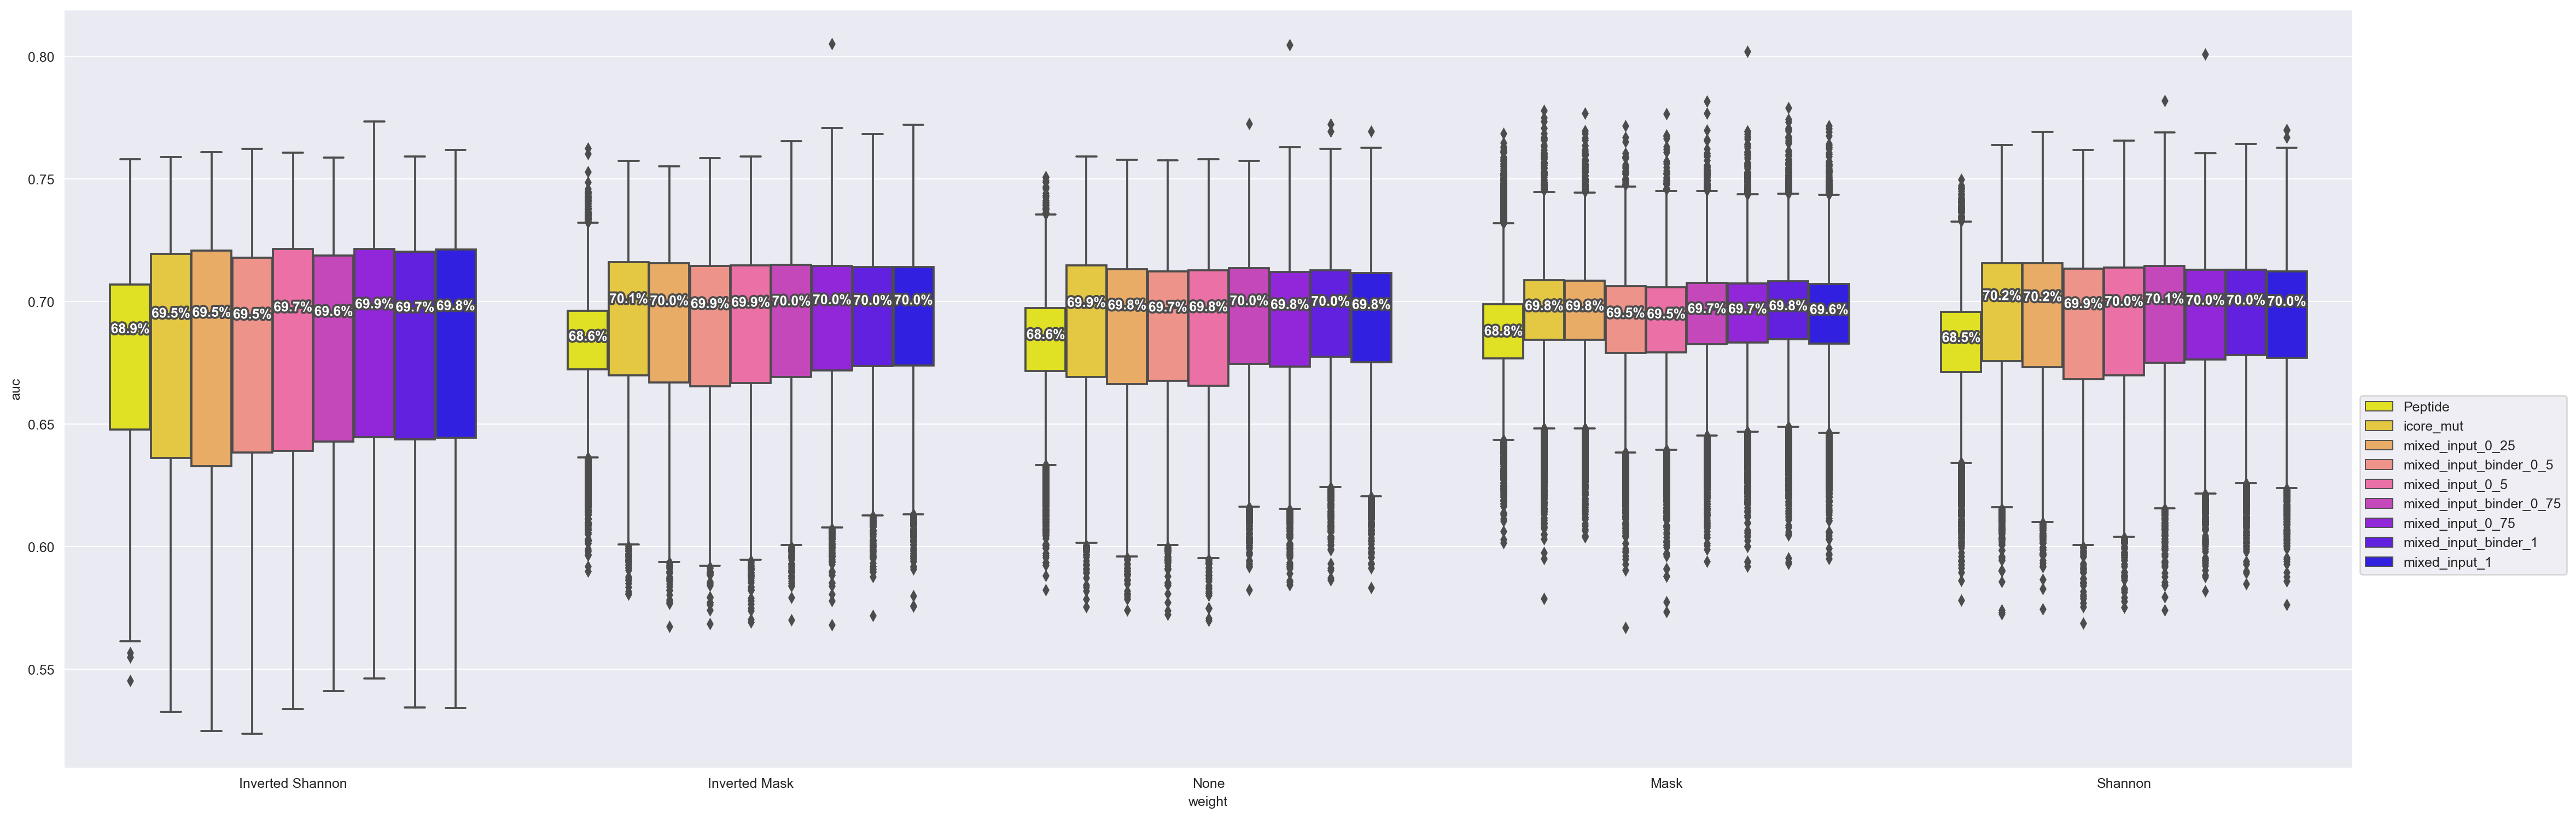

In [30]:
f,a =plt.subplots(1,1, figsize=(30,10))
sns.boxplot(concat.query('not weight.str.contains("KL")'), 
            order = ['Inverted Shannon', 'Inverted Mask', 'None', 'Mask', 'Shannon'],
            x='weight', hue='input_type', y='auc', ax=a)
a.legend(bbox_to_anchor=(1, .5))
add_median_labels(a)

## Do Expand 8mer stuff

In [31]:
def get_expanded_input(row):
    input_col = row['core_mut'] if row['len_icore_mut']==8 else row['icore_mut']
    return input_col
cedar_aligned['expanded_input'] = cedar_aligned.apply(get_expanded_input,axis=1)
cedar_aligned.query('expanded_input.str.contains("-")')

,Unnamed: 0.1,Unnamed: 0,HLA,agg_label,fold,Peptide,wild_type,icore_mut,core_mut,len,...,icore_improves_binder_0_75,mixed_input_binder_0_75,mixed_rank_binder_0_75,icore_improves_1,mixed_input_1,mixed_rank_1,icore_improves_binder_1,mixed_input_binder_1,mixed_rank_binder_1,expanded_input
39,39,39,HLA-A0201,0,9,AIYHTLNLFNI,AIYHTLNLCNI,AIYHTLNL,AIY-HTLNL,11,...,False,AIYHTLNLFNI,5.8573,False,AIYHTLNLFNI,5.8573,False,AIYHTLNLFNI,5.8573,AIY-HTLNL
40,40,40,HLA-B0702,0,7,AKNCGIAIPV,AKNRGIAIPV,AKNCGIAI,-AKNCGIAI,10,...,False,AKNCGIAIPV,52.6923,False,AKNCGIAIPV,52.6923,False,AKNCGIAIPV,52.6923,-AKNCGIAI
105,105,105,HLA-B1501,0,5,ALSIGTSYRY,ALSIGTPYRY,ALSIGTSY,ALS-IGTSY,10,...,False,ALSIGTSYRY,0.4303,False,ALSIGTSYRY,0.4303,False,ALSIGTSYRY,0.4303,ALS-IGTSY
133,133,133,HLA-A0201,0,9,AMYLNYFRGL,AMYLNYCRGL,YLNYFRGL,YLN-YFRGL,10,...,False,AMYLNYFRGL,6.1562,False,AMYLNYFRGL,6.1562,False,AMYLNYFRGL,6.1562,YLN-YFRGL
158,158,158,HLA-B0702,0,4,APTWRALAR,APTWRALAG,APTWRALA,APT-WRALA,9,...,False,APTWRALAR,2.6840,False,APTWRALAR,2.6840,False,APTWRALAR,2.6840,APT-WRALA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2838,2838,2838,HLA-C1403,0,4,WYTHNLIFVF,WYTHNLFFVF,WYTHNLIF,WYT-HNLIF,10,...,True,WYTHNLIF,0.5629,True,WYTHNLIF,0.5629,True,WYTHNLIF,0.5629,WYT-HNLIF
2869,2869,2869,HLA-A0201,1,4,YKLVVVGAV,YKLVVVGAG,KLVVVGAV,KLV-VVGAV,9,...,False,YKLVVVGAV,27.7097,True,KLVVVGAV,7.6549,False,YKLVVVGAV,27.7097,KLV-VVGAV
2933,2933,2933,HLA-A1101,1,6,YMKSLEFENK,YMKSSEFENK,KSLEFENK,KSLE-FENK,10,...,False,YMKSLEFENK,3.9487,False,YMKSLEFENK,3.9487,False,YMKSLEFENK,3.9487,KSLE-FENK
3013,3013,3013,HLA-A0201,0,3,YVMASVFVCPL,YVMASVFVCLL,YVMASVFV,YVMASVF-V,11,...,False,YVMASVFVCPL,3.6690,False,YVMASVFVCPL,3.6690,False,YVMASVFVCPL,3.6690,YVMASVF-V


In [32]:
from sklearn.ensemble import RandomForestClassifier
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn

encoding_kwargs = {'max_len': 12, 'encoding': 'onehot', 'blosum_matrix': 'None', 'add_rank': True, 
               'rank_col':'EL_rank_mut', 'seq_col':'expanded_input',
                   'target_col': 'agg_label', 'hla_col': 'HLA', 'add_aaprop': False, 'remove_pep': False,
                   'mask': False, 'invert': False,'standardize':True} 
odir = '../output/230415_exprscore_analysis_FINAL/icore_pep_detour/'
bdfs = []
for ic_name, ics_dict, mask, invert in [('Inverted Shannon', ics_shannon, False, True),
                                        ('Inverted Mask', ics_shannon, True, True),
                                        ('None', None, False, False),
                                        ('Mask', ics_shannon, True, False),
                                        ('Shannon', ics_shannon, False, False)]:
    encoding_kwargs['mask']=mask
    encoding_kwargs['invert']=invert
    encoding_kwargs['standardize'] = True
    model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                               max_depth=8, ccp_alpha=9.945e-6)
    # Training model and getting feature importances
    print('Training')
    trained_models, _, _ = nested_kcv_train_sklearn(cedar_aligned, model,
                                                    ics_dict=ics_dict,
                                                    encoding_kwargs=encoding_kwargs,
                                                    n_jobs=8)
    
    _, kcv_preds = evaluate_trained_models_sklearn(cedar_aligned,
                                                trained_models, ics_dict,
                                                cedar_aligned,
                                                encoding_kwargs, concatenated=False,
                                                only_concat=True, n_jobs=8)
    p_col = 'pred' if 'pred' in kcv_preds.columns else 'mean_pred'
    bdf = bootstrap_eval(kcv_preds[p_col], kcv_preds['agg_label'], n_rounds=10000, n_jobs=8, add_roc=False)
    bdf['input_type'] = encoding_kwargs['seq_col']
    bdf['weight'] = ic_name
    bdf['evalset'] = 'CEDAR'
    bdfs.append(bdf)
    
    _, kcv_preds = evaluate_trained_models_sklearn(prime_aligned,
                                                trained_models, ics_dict,
                                                cedar_aligned,
                                                encoding_kwargs, concatenated=False,
                                                only_concat=True, n_jobs=8)
    p_col = 'pred' if 'pred' in kcv_preds.columns else 'mean_pred'
    bdf = bootstrap_eval(kcv_preds[p_col], kcv_preds['agg_label'], n_rounds=10000, n_jobs=8, add_roc=False)
    bdf['input_type'] = encoding_kwargs['seq_col']
    bdf['weight'] = ic_name
    bdf['evalset'] = 'PRIME'
    bdfs.append(bdf)

Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


In [33]:
concat = concat.append(pd.concat(bdfs))
del bdfs
# concat=concat.append(pd.read_csv('../output/230415_exprscore_analysis_FINAL/df_input_comp_prime.csv'))
concat.to_csv('../output/230415_exprscore_analysis_FINAL/bootstrapped_dfs_new_inputs.csv')


In [34]:
input_order = list(concat.input_type.unique())
weight_order = ['Inverted Shannon', 'Inverted Mask', 'None', 'Mask', 'Shannon']
input_order

['Peptide',
 'icore_mut',
 'mixed_input_0_25',
 'mixed_input_binder_0_5',
 'mixed_input_0_5',
 'mixed_input_binder_0_75',
 'mixed_input_0_75',
 'mixed_input_binder_1',
 'mixed_input_1',
 'expanded_input']

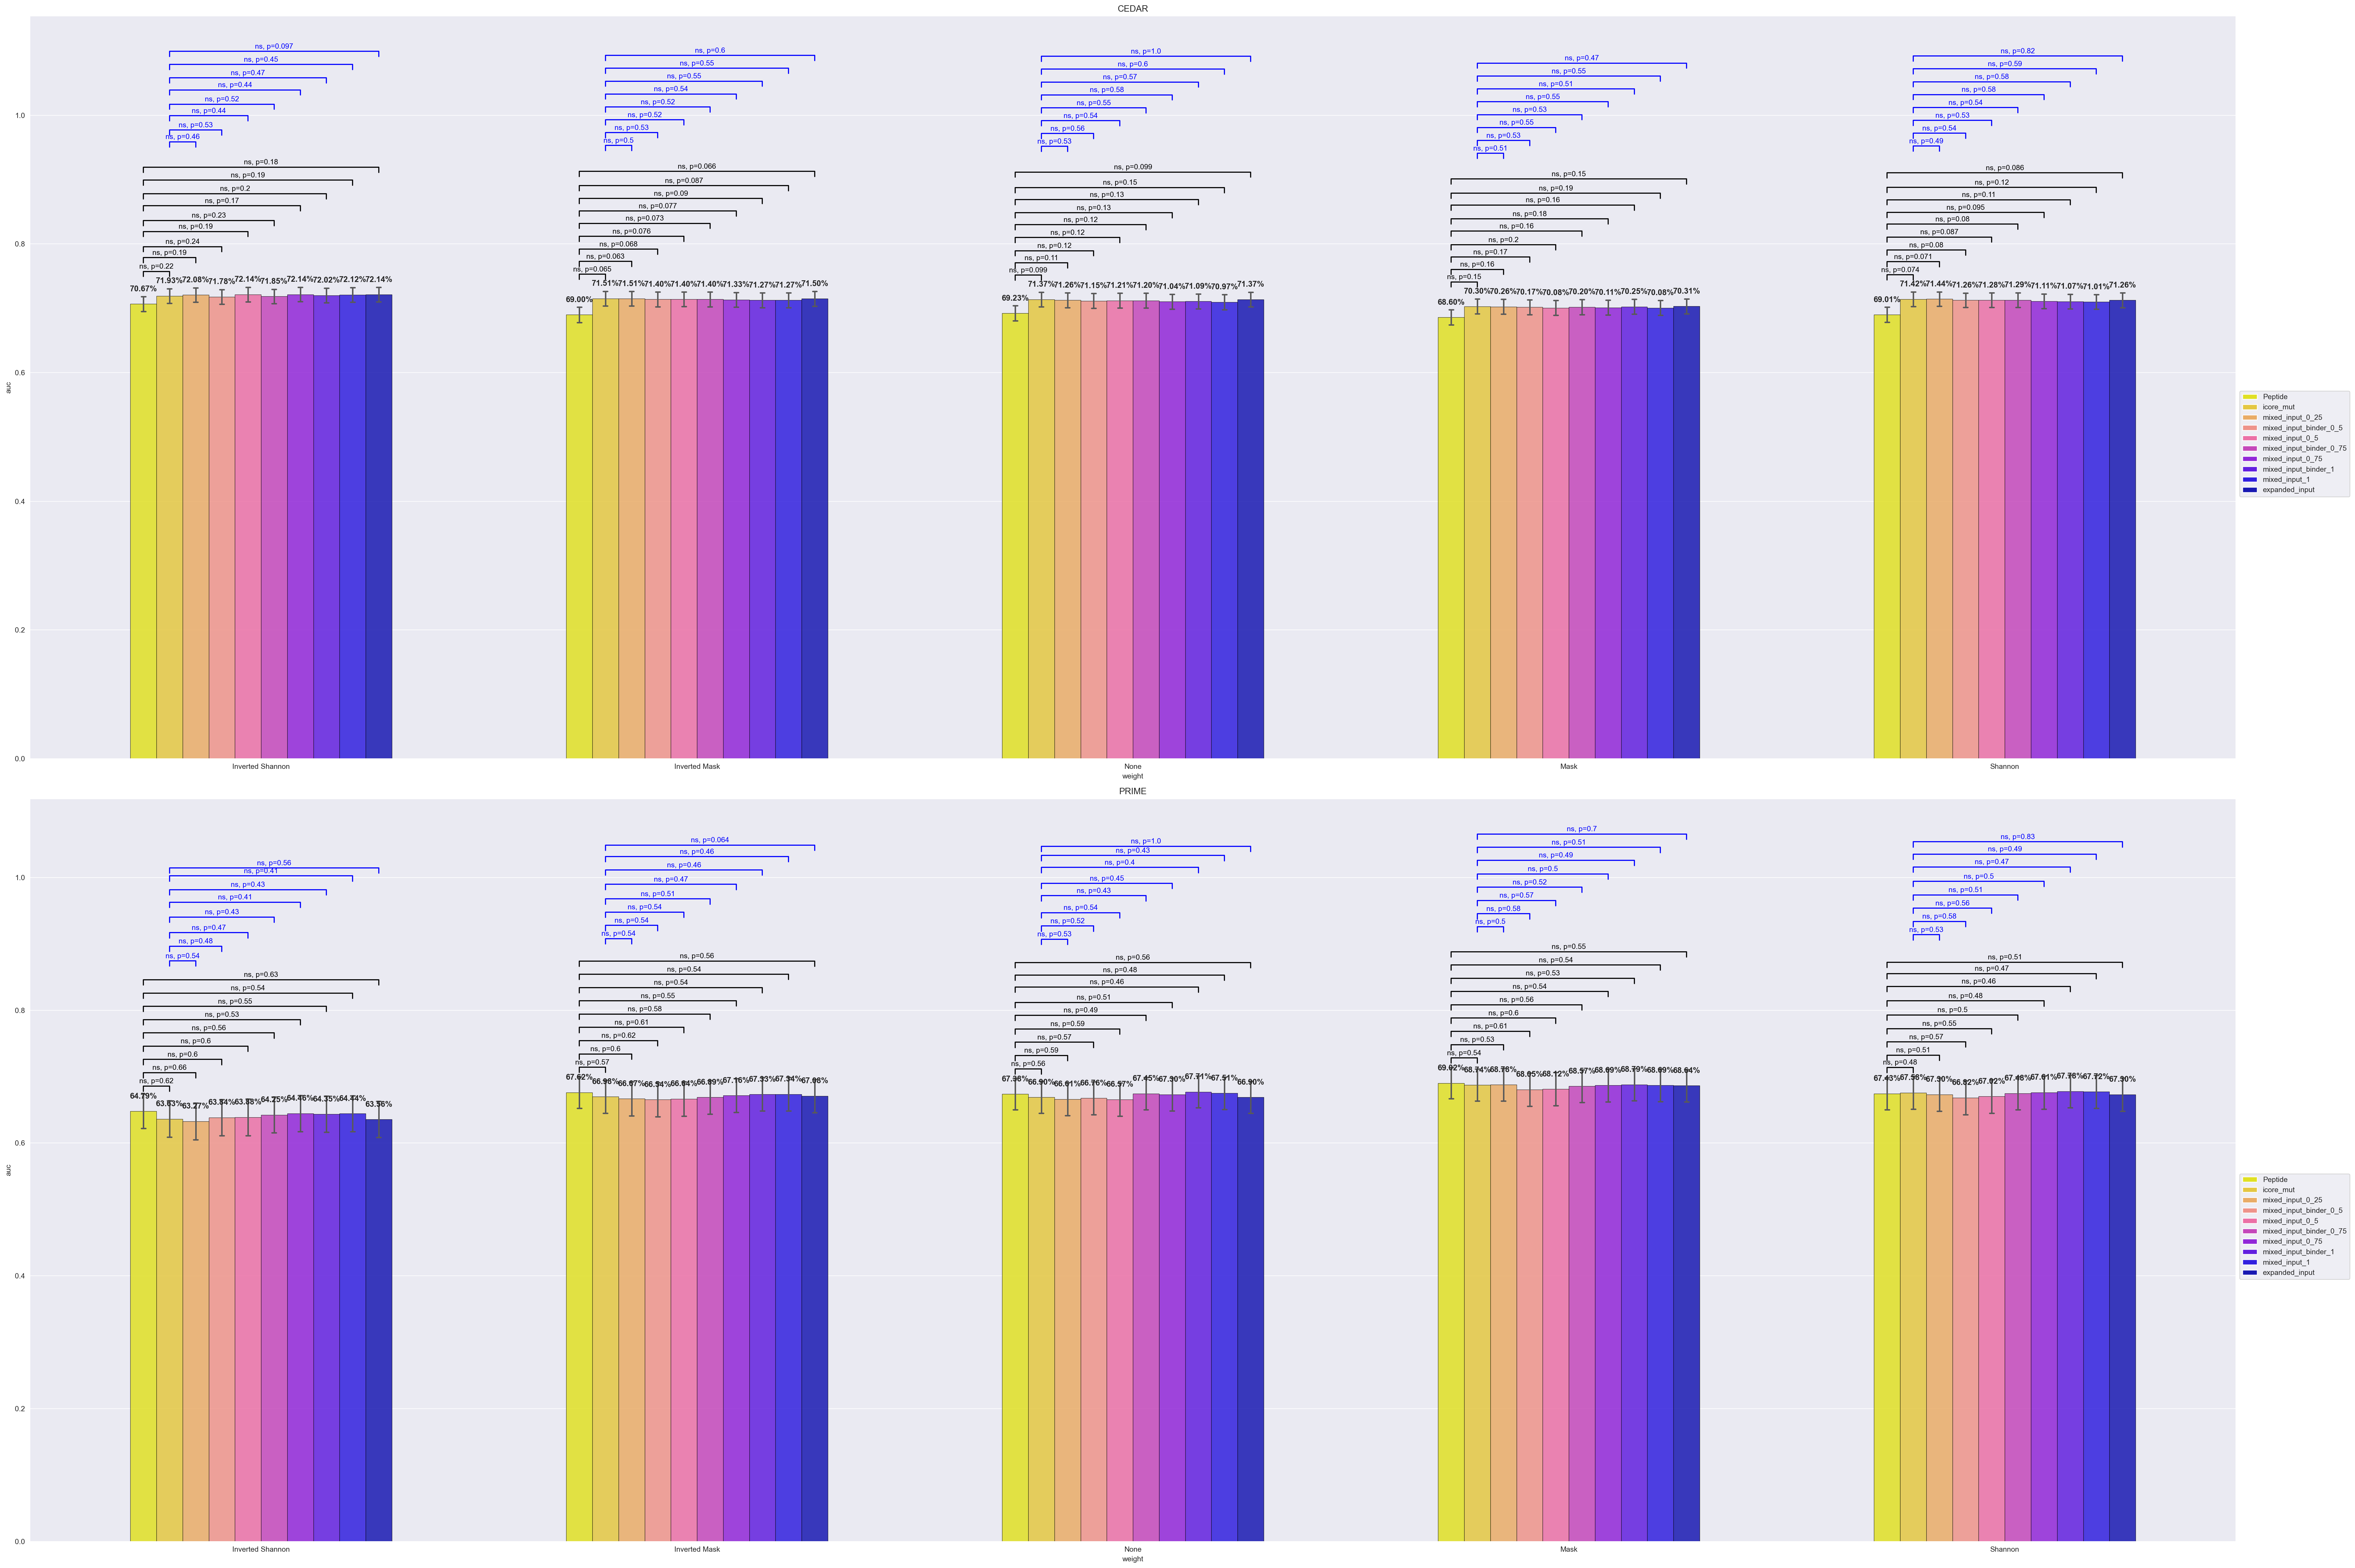

In [43]:
f,ax =plt.subplots(2,1, figsize=(45,30))
for evalset, a in zip(['CEDAR', 'PRIME'], ax.ravel()):
    a.set_title(evalset)
    df = concat.query('not weight.str.contains("KL") and evalset==@evalset')
    sns.barplot(df, order = weight_order, errorbar='sd', errcolor='.35',
                errwidth=2, capsize=.01, width=.6,
                x='weight', hue='input_type', y='auc', ax=a)
    a.legend(bbox_to_anchor=(1, .5))
    for container in a.containers:
        values = [f'{x:.2%}' for x in container.datavalues]
        a.bar_label(container, labels=values, fontsize=11, fontweight='semibold', padding=15)
    plt.setp(a.patches, linewidth=0.5, edgecolor='k', alpha=0.85)
    dx = a.patches[0].get_width()
    # a.set_ylim([0.5, 0.8])

    for i, weight in enumerate(weight_order):
        x0 = i
        xs = [x0-4.5*dx, x0-3.5*dx, x0-2.5*dx, x0-1.5*dx, x0-.5*dx,
              x0+.5*dx, x0+1.5*dx, x0+2.5*dx, x0+3.5*dx, x0+4.5*dx]
        # First compare to base
        h, h0 = 0.03, 0.01
        x1 = xs[input_order.index('Peptide')]
        aucs_base = df.query("weight==@weight and input_type=='Peptide'").auc.values
        for i, comp in enumerate(input_order):
            if comp=='Peptide':continue
            aucs_comp = df.query("weight==@weight and input_type==@comp").auc.values
            pval, sig = get_pval(aucs_comp, aucs_base)
            plot_pval(a, pval, sig, x1, xs[i], y=max(np.mean(aucs_base),np.mean(aucs_comp))+h, h=h0, color='k')
            h+=2*h0

        # Then compare to ICORE
        h += 2*h0
        x1 = xs[input_order.index('icore_mut')]
        aucs_base = df.query("weight==@weight and input_type=='icore_mut'").auc.values
        for i, comp in enumerate(input_order):
            if comp=='icore_mut' or comp=='Peptide':continue
            aucs_comp = df.query("weight==@weight and input_type==@comp").auc.values
            pval, sig = get_pval(aucs_comp, aucs_base)
            plot_pval(a, pval, sig, x1, xs[i], y=max(np.mean(aucs_base),np.mean(aucs_comp))+h, h=h0, color='b')
            h+=2*h0
f.tight_layout()

In [152]:
cedar_aligned_expr['expanded_input'] = cedar_aligned_expr.apply(get_expanded_input, axis=1)
prime_aligned_expr['expanded_input'] = prime_aligned_expr.apply(get_expanded_input, axis=1)
nepdb_aligned_expr['expanded_input'] = nepdb_aligned_expr.apply(get_expanded_input, axis=1)

cedar_aligned_expr.query('expanded_input.str.contains("-")')
cedar_aligned_expr.to_csv('../data/pepx/230418_cedar_aligned_pepx.csv')
prime_aligned_expr.to_csv('../data/pepx/230418_prime_aligned_pepx.csv')
nepdb_aligned_expr.to_csv('../data/pepx/230418_nepdb_aligned_pepx.csv')

,Unnamed: 0.1,Unnamed: 0,Peptide,HLA,EL_rank_mut,agg_label,fold,EL_rank_wt,EL_rank_wt_aligned,Total_Gene_TPM,...,len_icore_mut,seq_id,trueHLA_EL_rank,wild_type,foreignness_score,ratio_rank,impr_icore,impr_pep,ic_len,expanded_input
39,39,39,AIYHTLNLFNI,HLA-A0201,4.7939,0,5,3.4539,4.7939,32.330000,...,8,>seq_40,5.8573,AIYHTLNLCNI,2.049193e-13,0.000000,False,False,353,AIY-HTLNL
40,40,40,AKNCGIAIPV,HLA-B0702,33.2727,0,4,7.5456,16.9099,4.721020,...,8,>seq_41,52.6923,AKNRGIAIPV,0.000000e+00,32.196201,False,False,17862,-AKNCGIAI
103,103,103,ALSIGTSYRY,HLA-B1501,0.3522,0,3,0.4894,0.8871,0.001000,...,8,>seq_106,0.4303,ALSIGTPYRY,0.000000e+00,0.212368,True,False,3004,ALS-IGTSY
131,131,131,AMYLNYFRGL,HLA-A0201,5.4228,0,7,9.5592,9.7252,87.822400,...,8,>seq_134,6.1562,AMYLNYCRGL,7.619771e-03,2.399031,False,False,353,YLN-YFRGL
155,155,155,APTWRALAR,HLA-B0702,2.3117,0,9,1.4481,2.3117,6.321210,...,8,>seq_159,2.6840,APTWRALAG,0.000000e+00,0.000000,False,False,17862,APT-WRALA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2794,2794,2794,WYTHNLIFVF,HLA-C1403,0.5629,0,1,0.6155,0.6155,2.281050,...,8,>seq_2839,2.8869,WYTHNLFFVF,0.000000e+00,0.048105,False,False,27298,WYT-HNLIF
2824,2824,2824,YKLVVVGAV,HLA-A0201,7.6549,1,6,46.6000,46.6000,83.541700,...,8,>seq_2870,27.7097,YKLVVVGAG,5.895247e-05,6.397443,False,False,353,KLV-VVGAV
2888,2888,2888,YMKSLEFENK,HLA-A1101,3.9345,1,2,2.7059,4.0461,8.350720,...,8,>seq_2934,3.9487,YMKSSEFENK,0.000000e+00,0.108522,False,False,79,KSLE-FENK
2968,2968,2968,YVMASVFVCPL,HLA-A0201,3.0785,0,0,0.5738,3.0785,19.341100,...,8,>seq_3014,3.6690,YVMASVFVCLL,0.000000e+00,0.000000,False,False,353,YVMASVF-V


In [237]:
cedar_old = pd.read_csv('../data/pepx/230308_cedar_aligned_pepx_fold.csv')
cedar_new = pd.read_csv('../data/pepx/230418_cedar_aligned_pepx.csv')

In [207]:
a=df.query("weight=='None' and input_type=='Peptide'").auc.values
b=df.query("weight=='None' and input_type=='expanded_input'").auc.values
get_pval(b,a)

(0.5676, 'ns')

In [157]:
'icore_dissimilarity_score-icore_blsm_mut_score'.replace('icore','')

'_dissimilarity_score-_blsm_mut_score'

In [209]:
import itertools
mcs = []
cols_ = ['icore_aliphatic_index', 'icore_boman', 'icore_hydrophobicity', 'icore_isoelectric_point', 'icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank', 'EL_rank_wt_aligned', 'foreignness_score', 'Total_Gene_TPM'] 
    
    
for L in range(0, len(cols_) + 1):
    for mc in itertools.combinations(cols_, L):
        mcs.append(list(mc))
len(mcs)

1024

# Expand 8mers Expr/Mutscores

In [44]:
old_gb_merged = pd.read_csv('../output/230415_exprscore_analysis_FINAL/gb_merged_final.csv').set_index(['weight','key', 'which'])

new_gb_merged = pd.read_csv('../output/230418_expand_8mers/gb_merged_exp8mers_pvals_FINAL.csv').assign(which='expand8mers').set_index(['weight','key', 'which'])


In [50]:
new_gb_merged.pval_base_ICORE_CEDAR.unique()

array([1000])

In [45]:
concat_gb = pd.concat([old_gb_merged, new_gb_merged])

In [54]:
len(cedar_aligned)

3033

In [55]:
n_human = [int(x*3033) for x in np.arange(0, 10, 0.1) if x*3033 <= 100000]
p_human = [round(100 * x / (x+3033),2) for x in n_human]

In [48]:
for c in ['mean_auc_PRIME']:
    print('#'*30,'\n'*3, c, '\n', '#'*30,'\n'*3)
    print('\t\tALL')
    display(concat_gb.sort_values(c,ascending=False).head(50).reset_index().groupby(['which']).first().reset_index().set_index(['which','weight','key'])\
           [['mean_auc_CEDAR', 'mean_auc_PRIME','mean_auc01_PRIME', 'pval_base_ICORE_PRIME', 'pval_base_pep_PRIME']])
    print('\t\t SIG only')
    f = 'PRIME' if 'PRIME' in c else 'CEDAR'
    display(concat_gb.query(f'pval_base_ICORE_{f} < 0.05 or pval_base_pep_{f}<0.05')\
            .sort_values(c, ascending=False).head(50).reset_index().groupby(['which']).first().reset_index().set_index(['which','weight','key'])\
           [['mean_auc_CEDAR', 'mean_auc_PRIME','mean_auc01_PRIME', 'pval_base_ICORE_PRIME', 'pval_base_pep_PRIME']])

############################## 


 mean_auc_PRIME 
 ############################## 



		ALL


,,,mean_auc_CEDAR,mean_auc_PRIME,mean_auc01_PRIME,pval_base_ICORE_PRIME,pval_base_pep_PRIME
which,weight,key,,,,,
addforeignness,Mask,icore_dissimilarity_score-ratio_rank-Total_Gene_TPM,0.709348,0.725922,0.606484,0.1518,0.2433
allcombi,Mask,icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM,0.719055,0.723130,0.600770,0.1519,0.2259
expand8mers,Inv-Mask,dissimilarity_score-blsm_mut_score-ratio_rank,0.715367,0.720991,0.593588,1000.0000,1000.0000
original,Mask,icore_dissimilarity_score-icore_blsm_mut_score,0.709356,0.729706,0.594233,0.1367,0.2278


		 SIG only


,,,mean_auc_CEDAR,mean_auc_PRIME,mean_auc01_PRIME,pval_base_ICORE_PRIME,pval_base_pep_PRIME
which,weight,key,,,,,
allcombi,None,icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank,0.714609,0.720663,0.606817,0.0341,0.2347


## Check why the condition above has different results??

In [242]:
cedar_old.loc[(cedar_old['ratio_rank']==cedar_new['ratio_rank'])==False].index

Int64Index([543, 2808, 2943, 2971], dtype='int64')

In [278]:
a=cedar_new.loc[cedar_old.loc[(cedar_old['ratio_rank']==cedar_new['ratio_rank'])==False].index]
b=cedar_old.loc[cedar_old.loc[(cedar_old['ratio_rank']==cedar_new['ratio_rank'])==False].index]
ycols =['HLA','agg_label','Peptide', 'icore_mut', 'expanded_input']
xcols=['EL_rank_mut', 'EL_rank_wt_aligned', 'trueHLA_EL_rank', 'EL_rank_wt', 'ratio_rank','icore_blsm_mut_score', 'icore_dissimilarity_score']

In [282]:
a.loc[a[c]-b[c] != 0]

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Peptide,HLA,EL_rank_mut,agg_label,fold,EL_rank_wt,EL_rank_wt_aligned,...,len_icore_mut,seq_id,trueHLA_EL_rank,wild_type,foreignness_score,ratio_rank,impr_icore,impr_pep,ic_len,expanded_input


In [337]:
from src.data_processing import encode_batch_weighted, get_ic_weights
sample = cedar_new.query('len_icore_mut==8').head()

encode_batch_weighted(sample, seq_col = 'core_mut', max_len=12)[0].shape
weights = get_ic_weights(cedar_old.sample(1), ics_shannon, 12, 'icore_mut', 'HLA',False,False)


In [339]:
weights.shape

(1, 12, 20)

In [325]:
cedar_new.query('len_icore_mut==8')[['core_mut', 'icore_mut']]

,core_mut,icore_mut
39,AIY-HTLNL,AIYHTLNL
40,-AKNCGIAI,AKNCGIAI
103,ALS-IGTSY,ALSIGTSY
131,YLN-YFRGL,YLNYFRGL
155,APT-WRALA,APTWRALA
...,...,...
2794,WYT-HNLIF,WYTHNLIF
2824,KLV-VVGAV,KLVVVGAV
2888,KSLE-FENK,KSLEFENK
2968,YVMASVF-V,YVMASVFV


In [320]:
from copy import deepcopy

cdt_old = (dict(max_len=12, encoding='onehot', blosum_matrix=None, mask=False, add_rank=True, invert=False,
          add_aaprop=False, remove_pep=False, standardize=True, target_col='agg_label', seq_col='icore_mut',
          rank_col='EL_rank_mut', hla_col='HLA',
          mut_col=['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank']),
                  None, 'None', 'MessyCdt_old')

cdt_new = (dict(max_len=12, encoding='onehot', blosum_matrix=None, mask=False, add_rank=True, invert=False,
          add_aaprop=False, remove_pep=False, standardize=True, target_col='agg_label', seq_col='expanded_input',
          rank_col='EL_rank_mut', hla_col='HLA',
          mut_col=['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank']),
                  None, 'None', 'MessyCdt_new')

kw_old = deepcopy(cdt_old[0])
kw_new = deepcopy(cdt_new[0])
kw_old.pop('standardize')
kw_new.pop('standardize')
x_old, _ = get_dataset(cedar_old, None, **kw_old)
x_new, _ = get_dataset(cedar_new, None, **kw_new)
print(np.where(x_old!=x_new))
print(cedar_new.)

(array([  39,   39,   39,   39,   39,   39,   39,   40,   40,   40,   40,
         40,   40,  103,  103,  103,  103,  103,  103,  103,  131,  131,
        131,  131,  131,  131,  155,  155,  155,  155,  155,  155,  177,
        177,  177,  177,  177,  177,  177,  177,  187,  187,  187,  187,
        187,  187,  195,  195,  195,  195,  195,  195,  195,  195,  225,
        225,  225,  225,  225,  225,  225,  284,  284,  284,  284,  284,
        284,  284,  291,  291,  291,  291,  291,  291,  291,  295,  295,
        295,  295,  295,  312,  312,  312,  312,  312,  312,  312,  318,
        318,  318,  318,  318,  318,  318,  364,  364,  364,  364,  364,
        364,  364,  381,  381,  381,  381,  381,  381,  381,  384,  384,
        384,  384,  384,  384,  384,  393,  393,  393,  393,  393,  393,
        398,  398,  398,  398,  398,  398,  416,  416,  416,  416,  416,
        416,  416,  416,  423,  423,  423,  423,  429,  429,  429,  429,
        429,  440,  440,  440,  440,  440,  440,  

In [319]:
from copy import deepcopy

cdt_old = (dict(max_len=12, encoding='onehot', blosum_matrix=None, mask=False, add_rank=True, invert=False,
          add_aaprop=False, remove_pep=False, standardize=True, target_col='agg_label', seq_col='icore_mut',
          rank_col='EL_rank_mut', hla_col='HLA',
          mut_col=['icore_dissimilarity_score', 'icore_blsm_mut_score']),
                  None, 'None', 'MessyCdt_old')

cdt_new = (dict(max_len=12, encoding='onehot', blosum_matrix=None, mask=False, add_rank=True, invert=False,
          add_aaprop=False, remove_pep=False, standardize=True, target_col='agg_label', seq_col='expanded_input',
          rank_col='EL_rank_mut', hla_col='HLA',
          mut_col=['icore_dissimilarity_score', 'icore_blsm_mut_score']),
                  None, 'None', 'MessyCdt_new')

kw_old = deepcopy(cdt_old[0])
kw_new = deepcopy(cdt_new[0])
kw_old.pop('standardize')
kw_new.pop('standardize')
x_old, _ = get_dataset(cedar_old, None, **kw_old)
x_new, _ = get_dataset(cedar_new, None, **kw_new)
print(np.where(x_old!=x_new))


(array([  39,   39,   39,   39,   39,   39,   39,   40,   40,   40,   40,
         40,   40,  103,  103,  103,  103,  103,  103,  103,  131,  131,
        131,  131,  131,  131,  155,  155,  155,  155,  155,  155,  177,
        177,  177,  177,  177,  177,  177,  177,  187,  187,  187,  187,
        187,  187,  195,  195,  195,  195,  195,  195,  195,  195,  225,
        225,  225,  225,  225,  225,  225,  284,  284,  284,  284,  284,
        284,  284,  291,  291,  291,  291,  291,  291,  291,  295,  295,
        295,  295,  295,  312,  312,  312,  312,  312,  312,  312,  318,
        318,  318,  318,  318,  318,  318,  364,  364,  364,  364,  364,
        364,  364,  381,  381,  381,  381,  381,  381,  381,  384,  384,
        384,  384,  384,  384,  384,  393,  393,  393,  393,  393,  393,
        398,  398,  398,  398,  398,  398,  416,  416,  416,  416,  416,
        416,  416,  416,  423,  423,  423,  423,  429,  429,  429,  429,
        429,  440,  440,  440,  440,  440,  440,  

In [283]:

for c in xcols:
    mask = (cedar_old[c]-cedar_new[c])!=0
    display(cedar_old[mask])

,Unnamed: 0.1,Unnamed: 0,Peptide,HLA,EL_rank_mut,agg_label,fold,EL_rank_wt,EL_rank_wt_aligned,Total_Gene_TPM,...,icore_mutation_position,icore_wt_aligned,isoelectric_point,len,len_icore_mut,seq_id,trueHLA_EL_rank,wild_type,foreignness_score,ratio_rank


,Unnamed: 0.1,Unnamed: 0,Peptide,HLA,EL_rank_mut,agg_label,fold,EL_rank_wt,EL_rank_wt_aligned,Total_Gene_TPM,...,icore_mutation_position,icore_wt_aligned,isoelectric_point,len,len_icore_mut,seq_id,trueHLA_EL_rank,wild_type,foreignness_score,ratio_rank


,Unnamed: 0.1,Unnamed: 0,Peptide,HLA,EL_rank_mut,agg_label,fold,EL_rank_wt,EL_rank_wt_aligned,Total_Gene_TPM,...,icore_mutation_position,icore_wt_aligned,isoelectric_point,len,len_icore_mut,seq_id,trueHLA_EL_rank,wild_type,foreignness_score,ratio_rank


,Unnamed: 0.1,Unnamed: 0,Peptide,HLA,EL_rank_mut,agg_label,fold,EL_rank_wt,EL_rank_wt_aligned,Total_Gene_TPM,...,icore_mutation_position,icore_wt_aligned,isoelectric_point,len,len_icore_mut,seq_id,trueHLA_EL_rank,wild_type,foreignness_score,ratio_rank


,Unnamed: 0.1,Unnamed: 0,Peptide,HLA,EL_rank_mut,agg_label,fold,EL_rank_wt,EL_rank_wt_aligned,Total_Gene_TPM,...,icore_mutation_position,icore_wt_aligned,isoelectric_point,len,len_icore_mut,seq_id,trueHLA_EL_rank,wild_type,foreignness_score,ratio_rank
543,543,543,FLWRKTSKYM,HLA-A0201,2.1418,0,6,17.6194,23.2909,18.64260,...,1,FSWRKTSKYM,10.901810,10,10,>seq_552,2.1418,FSWRKTSKYM,0.0,1.944843
2808,2808,2808,YIAKYIVPYM,HLA-A0201,3.5236,0,5,8.0175,8.0175,2.54101,...,2,YIEKYIVPYM,9.048931,10,10,>seq_2853,3.5236,YIEKYIVPYM,0.0,1.975018
2943,2943,2943,YTASTSDAV,HLA-A0201,2.3908,0,8,14.3014,14.3014,143.42000,...,0,DTASTSDAV,3.749987,9,9,>seq_2989,2.3908,DTASTSDAV,0.0,1.991124
2971,2971,2971,YVRRVFITDDL,HLA-B0702,7.0059,0,4,15.9407,15.9407,435.64200,...,10,YVRRVFITDDF,6.443164,11,11,>seq_3017,7.0059,YVRRVFITDDF,0.0,3.926823


,Unnamed: 0.1,Unnamed: 0,Peptide,HLA,EL_rank_mut,agg_label,fold,EL_rank_wt,EL_rank_wt_aligned,Total_Gene_TPM,...,icore_mutation_position,icore_wt_aligned,isoelectric_point,len,len_icore_mut,seq_id,trueHLA_EL_rank,wild_type,foreignness_score,ratio_rank


,Unnamed: 0.1,Unnamed: 0,Peptide,HLA,EL_rank_mut,agg_label,fold,EL_rank_wt,EL_rank_wt_aligned,Total_Gene_TPM,...,icore_mutation_position,icore_wt_aligned,isoelectric_point,len,len_icore_mut,seq_id,trueHLA_EL_rank,wild_type,foreignness_score,ratio_rank


In [298]:

for c in xcols:
    mask = (cedar_old[c]-cedar_new[c])!=0
    display(cedar_old.loc[mask,c]-cedar_new.loc[mask,c])

Series([], Name: EL_rank_mut, dtype: float64)

Series([], Name: EL_rank_wt_aligned, dtype: float64)

Series([], Name: trueHLA_EL_rank, dtype: float64)

Series([], Name: EL_rank_wt, dtype: float64)

543     4.440892e-16
2808   -4.440892e-16
2943    2.220446e-16
2971    4.440892e-16
Name: ratio_rank, dtype: float64

Series([], Name: icore_blsm_mut_score, dtype: int64)

Series([], Name: icore_dissimilarity_score, dtype: float64)

In [251]:
list(filter(lambda x: 'exp' in x.lower(), cedar_new.columns))

['expanded_input']

In [305]:
# Old : 

cedar_old = pd.read_csv('../data/pepx/230308_cedar_aligned_pepx_fold.csv')
cedar_new = pd.read_csv('../data/pepx/230418_cedar_aligned_pepx.csv')
prime_old = pd.read_csv('../data/pepx/230308_prime_aligned_pepx.csv')#25_prime_aligned_pepx.csv')
prime_new = pd.read_csv('../data/pepx/230418_prime_aligned_pepx.csv')
nepdb_old = pd.read_csv('../data/pepx/230308_nepdb_aligned_pepx.csv')
nepdb_new = pd.read_csv('../data/pepx/230418_nepdb_aligned_pepx.csv')


cdt_old = (dict(max_len=12, encoding='onehot', blosum_matrix=None, mask=False, add_rank=True, invert=False,
          add_aaprop=False, remove_pep=False, standardize=True, target_col='agg_label', seq_col='icore_mut',
          rank_col='EL_rank_mut', hla_col='HLA',
          mut_col=['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank']),
                  None, 'None', 'MessyCdt_old')

cdt_new = (dict(max_len=12, encoding='onehot', blosum_matrix=None, mask=False, add_rank=True, invert=False,
          add_aaprop=False, remove_pep=False, standardize=True, target_col='agg_label', seq_col='expanded_input',
          rank_col='EL_rank_mut', hla_col='HLA',
          mut_col=['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank']),
                  None, 'None', 'MessyCdt_new')

# mega_df=[]
preds_dict={}
df_fis = {}
mega_df= []
for (encoding_kwargs, ics_dict, weight, name), train_dataset, prime_dataset, nepdb_dataset in zip([cdt_old, cdt_new], 
                                                                    [cedar_old, cedar_new],
                                                                    [prime_old, prime_new],
                                                                    [nepdb_old, nepdb_new]):
    model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                                       max_depth=8, ccp_alpha=9.945e-6)
    # Training model and getting feature importances
    print('Training')
    trained_models, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model,
                                                                ics_dict=ics_dict,
                                                                encoding_kwargs=encoding_kwargs,
                                                                n_jobs=15)
    fi = get_nested_feature_importance(trained_models)
    fn = AA_KEYS + ['rank', 'diss', 'blsm', 'ratio']

    # Saving Feature importances as dataframe
    df_fi = pd.DataFrame(fi, index=fn).T
    df_fis[name]=df_fi
    preds_dict[name]={}
    for evalset, evalname in zip([train_dataset, prime_dataset, nepdb_dataset],
                                 ['CEDAR','PRIME','NEPDB']):
        _, preds  = evaluate_trained_models_sklearn(evalset, trained_models, ics_dict,
                                                train_dataset, encoding_kwargs,
                                                concatenated=False, only_concat=True)
        preds_dict[name][evalname] = preds
        # preds.to_csv(f'{args["outdir"]}raw/{evalname}_preds_{filename}.csv', index=False)
        pc = 'pred' if 'pred' in preds.columns else 'mean_pred'
        bootstrapped_df = bootstrap_eval(preds[pc], preds['agg_label'], n_jobs=8, add_roc=False)
        bootstrapped_df['cdt']=name
        bootstrapped_df['evalset']=evalname
        mega_df.append(bootstrapped_df)
        
        

cdt_old = (dict(max_len=12, encoding='onehot', blosum_matrix=None, mask=False, add_rank=True, invert=False,
          add_aaprop=False, remove_pep=False, standardize=True, target_col='agg_label', seq_col='icore_mut',
          rank_col='EL_rank_mut', hla_col='HLA',
          mut_col=['icore_dissimilarity_score', 'icore_blsm_mut_score']),
                  None, 'None', 'MessyCdt_oldNoRatio')

cdt_new = (dict(max_len=12, encoding='onehot', blosum_matrix=None, mask=False, add_rank=True, invert=False,
          add_aaprop=False, remove_pep=False, standardize=True, target_col='agg_label', seq_col='expanded_input',
          rank_col='EL_rank_mut', hla_col='HLA',
          mut_col=['icore_dissimilarity_score', 'icore_blsm_mut_score']),
                  None, 'None', 'MessyCdt_newNoRatio')

for (encoding_kwargs, ics_dict, weight, name), train_dataset, prime_dataset, nepdb_dataset in zip([cdt_old, cdt_new], 
                                                                    [cedar_old, cedar_new],
                                                                    [prime_old, prime_new],
                                                                    [nepdb_old, nepdb_new]):
    model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                                       max_depth=8, ccp_alpha=9.945e-6)
    # Training model and getting feature importances
    print('Training')
    trained_models, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model,
                                                                ics_dict=ics_dict,
                                                                encoding_kwargs=encoding_kwargs,
                                                                n_jobs=15)
    fi = get_nested_feature_importance(trained_models)
    fn = AA_KEYS + ['rank', 'diss', 'blsm']

    # Saving Feature importances as dataframe
    df_fi = pd.DataFrame(fi, index=fn).T
    df_fis[name]=df_fi
    preds_dict[name]={}
    for evalset, evalname in zip([train_dataset, prime_dataset, nepdb_dataset],
                                 ['CEDAR','PRIME','NEPDB']):
        _, preds  = evaluate_trained_models_sklearn(evalset, trained_models, ics_dict,
                                                train_dataset, encoding_kwargs,
                                                concatenated=False, only_concat=True)
        preds_dict[name][evalname] = preds
        # preds.to_csv(f'{args["outdir"]}raw/{evalname}_preds_{filename}.csv', index=False)
        pc = 'pred' if 'pred' in preds.columns else 'mean_pred'
        bootstrapped_df = bootstrap_eval(preds[pc], preds['agg_label'], n_jobs=8, add_roc=False)
        bootstrapped_df['cdt']=name
        bootstrapped_df['evalset']=evalname
        mega_df.append(bootstrapped_df)

Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


In [306]:
mega_df=pd.concat(mega_df)

In [309]:
len(cedar_old), len(cedar_new)

(2988, 2988)

In [311]:
preds_dict.keys()

dict_keys(['MessyCdt_old', 'MessyCdt_new', 'MessyCdt_oldNoRatio', 'MessyCdt_newNoRatio'])

In [315]:
preds_dict['MessyCdt_oldNoRatio']['CEDAR']

,Unnamed: 0.1,Unnamed: 0,Peptide,HLA,EL_rank_mut,agg_label,fold,EL_rank_wt,EL_rank_wt_aligned,Total_Gene_TPM,...,icore_wt_aligned,isoelectric_point,len,len_icore_mut,seq_id,trueHLA_EL_rank,wild_type,foreignness_score,ratio_rank,mean_pred
0,0,0,AAAAAAQQIQV,HLA-B0702,3.9712,0,5,1.0441,1.0441,4.410980,...,AAAAAAQQL,6.100000,11,9,>seq_1,26.7692,AAAAAAQQLQV,0.0,11.133129,0.111386
1,1,1,AAAAQQIQV,HLA-B0702,4.9092,0,5,4.7746,4.7746,4.410980,...,AAAAQQLQV,6.100000,9,9,>seq_2,4.9092,AAAAQQLQV,0.0,0.138394,0.133730
2,2,2,AAAAQQIQV,HLA-A0201,1.9555,0,5,2.2847,2.2847,4.410980,...,AAAAQQLQV,6.100000,9,9,>seq_3,1.9555,AAAAQQLQV,0.0,0.281766,0.126514
3,3,3,AAHFTVLLY,HLA-A1101,0.4196,0,6,0.5881,0.5881,8.350720,...,AAHFTALLY,7.542349,9,9,>seq_4,0.4196,AAHFTALLY,0.0,0.120222,0.258486
4,4,4,AAIAASRSV,HLA-C1203,0.0591,0,6,1.1729,1.1729,20.890900,...,AAIAASRSA,10.550002,9,9,>seq_5,0.0591,AAIAASRSA,0.0,0.056122,0.189527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2983,2980,2980,YYADAFDFY,HLA-A2402,0.2948,0,0,0.2451,0.2451,4.080940,...,YYADAFDSY,3.491881,9,9,>seq_3026,0.2948,YYADAFDSY,0.0,0.059778,0.272985
2984,2982,2982,YYLEGWRFL,HLA-A0201,2.5719,0,8,2.7499,2.7499,0.071002,...,YLEGWRLL,6.403313,9,8,>seq_3028,7.2266,YYLEGWRLL,0.0,0.166478,0.189046
2985,2983,2983,YYNFEGDIALL,HLA-A2402,0.6247,0,0,0.7584,0.7584,108.549000,...,SYNFEGDIALL,3.550073,11,11,>seq_3029,0.6247,SYNFEGDIALL,0.0,0.110130,0.161498
2986,2984,2984,YYPGKKEPF,HLA-A2402,0.0965,0,0,0.0817,0.0817,12671.500000,...,YYSGKKEPF,9.121620,9,9,>seq_3030,0.0965,YYSGKKEPF,1.0,0.017481,0.218139


In [314]:
preds_dict['MessyCdt_newNoRatio']['CEDAR']

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Peptide,HLA,EL_rank_mut,agg_label,fold,EL_rank_wt,EL_rank_wt_aligned,...,seq_id,trueHLA_EL_rank,wild_type,foreignness_score,ratio_rank,impr_icore,impr_pep,ic_len,expanded_input,mean_pred
0,0,0,0,AAAAAAQQIQV,HLA-B0702,3.9712,0,5,1.0441,1.0441,...,>seq_1,26.7692,AAAAAAQQLQV,0.0,11.133129,False,False,73978,AAAAAAQQI,0.114288
1,1,1,1,AAAAQQIQV,HLA-B0702,4.9092,0,5,4.7746,4.7746,...,>seq_2,4.9092,AAAAQQLQV,0.0,0.138394,False,False,73978,AAAAQQIQV,0.137311
2,2,2,2,AAAAQQIQV,HLA-A0201,1.9555,0,5,2.2847,2.2847,...,>seq_3,1.9555,AAAAQQLQV,0.0,0.281766,False,False,83295,AAAAQQIQV,0.131730
3,3,3,3,AAHFTVLLY,HLA-A1101,0.4196,0,6,0.5881,0.5881,...,>seq_4,0.4196,AAHFTALLY,0.0,0.120222,False,False,74135,AAHFTVLLY,0.265356
4,4,4,4,AAIAASRSV,HLA-C1203,0.0591,0,6,1.1729,1.1729,...,>seq_5,0.0591,AAIAASRSA,0.0,0.056122,True,True,94776,AAIAASRSV,0.188092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2983,2980,2980,2980,YYADAFDFY,HLA-A2402,0.2948,0,0,0.2451,0.2451,...,>seq_3026,0.2948,YYADAFDSY,0.0,0.059778,False,False,52592,YYADAFDFY,0.270089
2984,2982,2982,2982,YYLEGWRFL,HLA-A0201,2.5719,0,8,2.7499,2.7499,...,>seq_3028,7.2266,YYLEGWRLL,0.0,0.166478,False,False,353,YL-EGWRFL,0.179925
2985,2983,2983,2983,YYNFEGDIALL,HLA-A2402,0.6247,0,0,0.7584,0.7584,...,>seq_3029,0.6247,SYNFEGDIALL,0.0,0.110130,False,False,12798,YYNFEGDIALL,0.164232
2986,2984,2984,2984,YYPGKKEPF,HLA-A2402,0.0965,0,0,0.0817,0.0817,...,>seq_3030,0.0965,YYSGKKEPF,1.0,0.017481,False,False,52592,YYPGKKEPF,0.216175


In [308]:
mega_df.groupby(['cdt','evalset']).agg(mean_auc=('auc','mean'))

mean_auc
cdt                 evalset          
MessyCdt_new        CEDAR    0.713784
                    NEPDB    0.707522
                    PRIME    0.685700
MessyCdt_newNoRatio CEDAR    0.719429
                    NEPDB    0.701050
                    PRIME    0.685919
MessyCdt_old        CEDAR    0.714609
                    NEPDB    0.706743
                    PRIME    0.686750
MessyCdt_oldNoRatio CEDAR    0.718835
                    NEPDB    0.698320
                    PRIME    0.685478

## other stuff


In [ ]:
old_preds = pd.read_csv('../output/230414_aligned_icore_exprscore_mutscore_filtered_aaprops/raw/

In [232]:
new_preds = pd.read_csv('../output/230418_expand_8mers/raw/CEDAR_preds_cedar_onehot_None_icore_mut_EL_rank_mut_dissimilarity_score-blsm_mut_score-ratio_rank.csv')


In [42]:
for c in ['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB', 'Compromise']:
    print('#'*30,'\n'*3, c, '\n', '#'*30,'\n'*3)
    print('\t\t','#'*10,'ALL','#'*10,)
    display(concat_gb.sort_values(c,ascending=False).head(50).reset_index().groupby(['which']).first().reset_index().set_index(['which','key']))
    print('\t\t','#'*10, 'SIG only','#'*10,)
    f = 'PRIME' if 'PRIME' in c else 'CEDAR'
    display(concat_gb.query(f'pval_base_ICORE_{f} < 0.05 or pval_base_pep_{f}<0.05')\
            .sort_values(c, ascending=False).head(50).reset_index().groupby(['which']).first().reset_index().set_index(['which','key']))

############################## 


 mean_auc_CEDAR 
 ############################## 



		 ########## ALL ##########


,,weight,mean_auc_CEDAR,mean_auc01_CEDAR,mean_auc_PRIME,mean_auc01_PRIME,mean_auc_NEPDB,mean_auc01_NEPDB,mean_auc_agg,mean_auc_std,Compromise,...,sig_base_ICORE_CEDAR,pval_base_pep_PRIME,sig_base_pep_PRIME,pval_base_ICORE_PRIME,sig_base_ICORE_PRIME,input_type,pval_base_pep_NEPDB,sig_base_pep_NEPDB,pval_base_ICORE_NEPDB,sig_base_ICORE_NEPDB
which,key,,,,,,,,,,,,,,,,,,,,,
allcombi,icore_boman-icore_isoelectric_point-icore_blsm_mut_score-Total_Gene_TPM,Inverted-Shannon,0.742721,0.586773,0.651842,0.520920,0.698537,0.542881,0.697281,0.045440,0.784321,...,**,0.6770,ns,0.9403,ns,None,NaN,None,NaN,None
expand8mers,boman-foreignness_score-Total_Gene_TPM,Inv-Shannon,0.743212,0.589100,0.645300,0.521482,0.698404,0.535116,0.694256,0.048956,0.782931,...,**,0.7072,ns,0.9448,ns,expand_8mers,0.1065,ns,0.5163,ns


		 ########## SIG only ##########


,,weight,mean_auc_CEDAR,mean_auc01_CEDAR,mean_auc_PRIME,mean_auc01_PRIME,mean_auc_NEPDB,mean_auc01_NEPDB,mean_auc_agg,mean_auc_std,Compromise,...,sig_base_ICORE_CEDAR,pval_base_pep_PRIME,sig_base_pep_PRIME,pval_base_ICORE_PRIME,sig_base_ICORE_PRIME,input_type,pval_base_pep_NEPDB,sig_base_pep_NEPDB,pval_base_ICORE_NEPDB,sig_base_ICORE_NEPDB
which,key,,,,,,,,,,,,,,,,,,,,,
allcombi,icore_boman-icore_isoelectric_point-icore_blsm_mut_score-Total_Gene_TPM,Inverted-Shannon,0.742721,0.586773,0.651842,0.520920,0.698537,0.542881,0.697281,0.045440,0.784321,...,**,0.6770,ns,0.9403,ns,None,NaN,None,NaN,None
expand8mers,boman-foreignness_score-Total_Gene_TPM,Inv-Shannon,0.743212,0.589100,0.645300,0.521482,0.698404,0.535116,0.694256,0.048956,0.782931,...,**,0.7072,ns,0.9448,ns,expand_8mers,0.1065,ns,0.5163,ns


############################## 


 mean_auc_PRIME 
 ############################## 



		 ########## ALL ##########


,,weight,mean_auc_CEDAR,mean_auc01_CEDAR,mean_auc_PRIME,mean_auc01_PRIME,mean_auc_NEPDB,mean_auc01_NEPDB,mean_auc_agg,mean_auc_std,Compromise,...,sig_base_ICORE_CEDAR,pval_base_pep_PRIME,sig_base_pep_PRIME,pval_base_ICORE_PRIME,sig_base_ICORE_PRIME,input_type,pval_base_pep_NEPDB,sig_base_pep_NEPDB,pval_base_ICORE_NEPDB,sig_base_ICORE_NEPDB
which,key,,,,,,,,,,,,,,,,,,,,,
addforeignness,icore_dissimilarity_score-ratio_rank-Total_Gene_TPM,Mask,0.709348,0.567076,0.725922,0.606484,0.770625,0.643689,0.717635,0.008287,0.782011,...,ns,0.2433,ns,0.1518,ns,None,NaN,None,NaN,None
allcombi,icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM,Mask,0.719055,0.569606,0.723130,0.600770,0.778704,0.628211,0.721093,0.002037,0.789292,...,ns,0.2259,ns,0.1519,ns,None,NaN,None,NaN,None
expand8mers,dissimilarity_score-blsm_mut_score-ratio_rank,None,0.714609,0.582784,0.720663,0.606817,NaN,NaN,0.717636,0.003027,0.785956,...,ns,0.2347,ns,0.0332,*,expand_8mers,0.1051,ns,0.452,ns
original,icore_dissimilarity_score-icore_blsm_mut_score,Mask,0.709356,0.565538,0.729706,0.594233,0.716671,0.615072,0.719531,0.010175,0.782017,...,ns,0.2278,ns,0.1367,ns,None,NaN,None,NaN,None


		 ########## SIG only ##########


,,weight,mean_auc_CEDAR,mean_auc01_CEDAR,mean_auc_PRIME,mean_auc01_PRIME,mean_auc_NEPDB,mean_auc01_NEPDB,mean_auc_agg,mean_auc_std,Compromise,...,sig_base_ICORE_CEDAR,pval_base_pep_PRIME,sig_base_pep_PRIME,pval_base_ICORE_PRIME,sig_base_ICORE_PRIME,input_type,pval_base_pep_NEPDB,sig_base_pep_NEPDB,pval_base_ICORE_NEPDB,sig_base_ICORE_NEPDB
which,key,,,,,,,,,,,,,,,,,,,,,
allcombi,icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank,None,0.714609,0.582784,0.720663,0.606817,0.706743,0.608754,0.717636,0.003027,0.785956,...,ns,0.2347,ns,0.0341,*,None,NaN,None,NaN,None
expand8mers,dissimilarity_score-blsm_mut_score-ratio_rank,None,0.714609,0.582784,0.720663,0.606817,0.721498,0.627979,0.717636,0.003027,0.785956,...,ns,0.2347,ns,0.0332,*,expand_8mers,0.1051,ns,0.452,ns


############################## 


 mean_auc_NEPDB 
 ############################## 



		 ########## ALL ##########


,,weight,mean_auc_CEDAR,mean_auc01_CEDAR,mean_auc_PRIME,mean_auc01_PRIME,mean_auc_NEPDB,mean_auc01_NEPDB,mean_auc_agg,mean_auc_std,Compromise,...,sig_base_ICORE_CEDAR,pval_base_pep_PRIME,sig_base_pep_PRIME,pval_base_ICORE_PRIME,sig_base_ICORE_PRIME,input_type,pval_base_pep_NEPDB,sig_base_pep_NEPDB,pval_base_ICORE_NEPDB,sig_base_ICORE_NEPDB
which,key,,,,,,,,,,,,,,,,,,,,,
addforeignness,icore_dissimilarity_score-ratio_rank-Total_Scaled_Peptide_TPM,Mask,0.709724,0.566423,0.725622,0.606112,0.773047,0.651930,0.717673,0.007949,0.782293,...,ns,0.2126,ns,0.1048,ns,None,NaN,None,NaN,None
allcombi,icore_dissimilarity_score-Total_Gene_TPM,Mask,0.716814,0.566666,0.718761,0.602706,0.785679,0.632074,0.717788,0.000974,0.787610,...,ns,0.2499,ns,0.1781,ns,None,NaN,None,NaN,None
expand8mers,dissimilarity_score-EL_rank_wt_aligned-Total_Gene_TPM,Shannon,0.722287,0.576126,0.695078,0.602797,0.782543,0.677727,0.708683,0.013604,0.784913,...,ns,0.3874,ns,0.4950,ns,expand_8mers,0.0195,*,0.0007,***
original,icore_dissimilarity_score-Total_Scaled_Peptide_TPM,Mask,0.716449,0.564223,0.721800,0.590688,0.771830,0.646195,0.719125,0.002675,0.787337,...,ns,0.2280,ns,0.1501,ns,None,NaN,None,NaN,None


		 ########## SIG only ##########


,,weight,mean_auc_CEDAR,mean_auc01_CEDAR,mean_auc_PRIME,mean_auc01_PRIME,mean_auc_NEPDB,mean_auc01_NEPDB,mean_auc_agg,mean_auc_std,Compromise,...,sig_base_ICORE_CEDAR,pval_base_pep_PRIME,sig_base_pep_PRIME,pval_base_ICORE_PRIME,sig_base_ICORE_PRIME,input_type,pval_base_pep_NEPDB,sig_base_pep_NEPDB,pval_base_ICORE_NEPDB,sig_base_ICORE_NEPDB
which,key,,,,,,,,,,,,,,,,,,,,,
addforeignness,icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-foreignness_score-Total_Peptide_TPM,Inverted-Shannon,0.726572,0.580271,0.663890,0.569376,0.756198,0.584112,0.695231,0.031341,0.779258,...,ns,0.5880,ns,0.8311,ns,None,NaN,None,NaN,None
allcombi,icore_aliphatic_index-icore_dissimilarity_score-Total_Gene_TPM,Mask,0.728559,0.584994,0.702201,0.551929,0.765012,0.590495,0.715380,0.013179,0.789830,...,ns,0.3380,ns,0.3812,ns,None,NaN,None,NaN,None
expand8mers,dissimilarity_score-blsm_mut_score-Total_Gene_TPM,Shannon,0.727157,0.575043,0.703719,0.592269,0.778325,0.656245,0.715438,0.011719,0.789508,...,ns,0.3334,ns,0.3689,ns,expand_8mers,0.0209,*,0.0009,***
original,icore_dissimilarity_score-EL_rank_wt_aligned-Total_Gene_TPM,Inverted-Shannon,0.727460,0.581581,0.659858,0.556278,0.761087,0.576509,0.693659,0.033801,0.778695,...,ns,0.6166,ns,0.8762,ns,None,NaN,None,NaN,None


############################## 


 Compromise 
 ############################## 



		 ########## ALL ##########


,,weight,mean_auc_CEDAR,mean_auc01_CEDAR,mean_auc_PRIME,mean_auc01_PRIME,mean_auc_NEPDB,mean_auc01_NEPDB,mean_auc_agg,mean_auc_std,Compromise,...,sig_base_ICORE_CEDAR,pval_base_pep_PRIME,sig_base_pep_PRIME,pval_base_ICORE_PRIME,sig_base_ICORE_PRIME,input_type,pval_base_pep_NEPDB,sig_base_pep_NEPDB,pval_base_ICORE_NEPDB,sig_base_ICORE_NEPDB
which,key,,,,,,,,,,,,,,,,,,,,,
allcombi,icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM,None,0.728096,0.576940,0.712474,0.578338,0.748349,0.607150,0.720285,0.007811,0.792167,...,*,0.2752,ns,0.1847,ns,None,NaN,None,NaN,None
expand8mers,blsm_mut_score-foreignness_score-Total_Gene_TPM,Inv-Mask,0.731566,0.584458,0.705557,0.555810,0.718032,0.560739,0.718562,0.013005,0.792172,...,*,0.3194,ns,0.3048,ns,expand_8mers,0.0808,ns,0.2782,ns
original,icore_dissimilarity_score-icore_blsm_mut_score-Total_Scaled_Peptide_TPM,None,0.727096,0.577801,0.715249,0.581739,0.742815,0.592627,0.721172,0.005924,0.792360,...,*,0.2590,ns,0.1367,ns,None,NaN,None,NaN,None


		 ########## SIG only ##########


,,weight,mean_auc_CEDAR,mean_auc01_CEDAR,mean_auc_PRIME,mean_auc01_PRIME,mean_auc_NEPDB,mean_auc01_NEPDB,mean_auc_agg,mean_auc_std,Compromise,...,sig_base_ICORE_CEDAR,pval_base_pep_PRIME,sig_base_pep_PRIME,pval_base_ICORE_PRIME,sig_base_ICORE_PRIME,input_type,pval_base_pep_NEPDB,sig_base_pep_NEPDB,pval_base_ICORE_NEPDB,sig_base_ICORE_NEPDB
which,key,,,,,,,,,,,,,,,,,,,,,
allcombi,icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM,None,0.728096,0.576940,0.712474,0.578338,0.748349,0.607150,0.720285,0.007811,0.792167,...,*,0.2752,ns,0.1847,ns,None,NaN,None,NaN,None
expand8mers,blsm_mut_score-foreignness_score-Total_Gene_TPM,Inv-Mask,0.731566,0.584458,0.705557,0.555810,0.718032,0.560739,0.718562,0.013005,0.792172,...,*,0.3194,ns,0.3048,ns,expand_8mers,0.0808,ns,0.2782,ns
original,icore_dissimilarity_score-icore_blsm_mut_score-Total_Scaled_Peptide_TPM,None,0.727096,0.577801,0.715249,0.581739,0.742815,0.592627,0.721172,0.005924,0.792360,...,*,0.2590,ns,0.1367,ns,None,NaN,None,NaN,None


In [ ]:
for c in ['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB', 'Compromise']:
    print('#'*30,'\n'*3, c, '\n', '#'*30,'\n'*3)
    print('\t\t OLD EXP')
    display(old_gb_merged.sort_values(c,ascending=False).head(2))
    print('\t\t SIG only')
    f = 'PRIME' if 'PRIME' in c else 'CEDAR'
    display(old_gb_merged.query(f'pval_base_ICORE_{f} < 0.05 or pval_base_pep_{f}<0.05')\
                .sort_values(c, ascending=False).head(2))

In [222]:
for c in ['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB', 'Compromise']:
    print('#'*30,'\n'*3, c, '\n', '#'*30,'\n'*3)
    print('\t\t NEW EXP')
    display(new_gb_merged.sort_values(c,ascending=False).head(2))
    print('\t\t SIG only')
    f = 'PRIME' if 'PRIME' in c else 'CEDAR'
    display(new_gb_merged.query(f'pval_base_ICORE_{f} < 0.05 or pval_base_pep_{f}<0.05')\
            .sort_values(c, ascending=False).head(2))

############################## 


 mean_auc_CEDAR 
 ############################## 



		 NEW EXP


mean_auc_CEDAR  \
weight      key                                    which                         
Inv-Shannon boman-foreignness_score-Total_Gene_TPM expand8mers        0.742440   
            boman-blsm_mut_score-Total_Gene_TPM    expand8mers        0.742389   

                                                                mean_auc01_CEDAR  \
weight      key                                    which                           
Inv-Shannon boman-foreignness_score-Total_Gene_TPM expand8mers          0.588327   
            boman-blsm_mut_score-Total_Gene_TPM    expand8mers          0.587802   

                                                                mean_auc_PRIME  \
weight      key                                    which                         
Inv-Shannon boman-foreignness_score-Total_Gene_TPM expand8mers        0.648807   
            boman-blsm_mut_score-Total_Gene_TPM    expand8mers        0.655507   

                                                                mean_auc01_PRIME  \
weight      key                                    which                           
Inv-Shannon boman-foreignness_score-Total_Gene_TPM expand8mers          0.521637   
            boman-blsm_mut_score-Total_Gene_TPM    expand8mers          0.520749   

                                                                mean_auc_NEPDB  \
weight      key                                    which                         
Inv-Shannon boman-foreignness_score-Total_Gene_TPM expand8mers        0.700220   
            boman-blsm_mut_score-Total_Gene_TPM    expand8mers        0.698318   

                                                                mean_auc01_NEPDB  \
weight      key                                    which                           
Inv-Shannon boman-foreignness_score-Total_Gene_TPM expand8mers          0.527777   
            boman-blsm_mut_score-Total_Gene_TPM    expand8mers          0.535475   

                                                                  input_type  \
weight      key                                    which                       
Inv-Shannon boman-foreignness_score-Total_Gene_TPM expand8mers  expand_8mers   
            boman-blsm_mut_score-Total_Gene_TPM    expand8mers  expand_8mers   

                                                                mean_auc_agg  \
weight      key                                    which                       
Inv-Shannon boman-foreignness_score-Total_Gene_TPM expand8mers      0.695624   
            boman-blsm_mut_score-Total_Gene_TPM    expand8mers      0.698948   

                                                                mean_auc_std  \
weight      key                                    which                       
Inv-Shannon boman-foreignness_score-Total_Gene_TPM expand8mers      0.046816   
            boman-blsm_mut_score-Total_Gene_TPM    expand8mers      0.043441   

                                                                Compromise  \
weight      key                                    which                     
Inv-Shannon boman-foreignness_score-Total_Gene_TPM expand8mers    0.783422   
            boman-blsm_mut_score-Total_Gene_TPM    expand8mers    0.785071   

                                                                ...  \
weight      key                                    which        ...   
Inv-Shannon boman-foreignness_score-Total_Gene_TPM expand8mers  ...   
            boman-blsm_mut_score-Total_Gene_TPM    expand8mers  ...   

                                                                pval_base_ICORE_CEDAR  \
weight      key                                    which                                
Inv-Shannon boman-foreignness_score-Total_Gene_TPM expand8mers                 0.0027   
            boman-blsm_mut_score-Total_Gene_TPM    expand8mers                 0.0032   

                                                               sig_base_ICORE_CEDAR  \
weight      key                                    which     

		 SIG only


mean_auc_CEDAR  \
weight      key                                    which                         
Inv-Shannon boman-foreignness_score-Total_Gene_TPM expand8mers        0.742440   
            boman-blsm_mut_score-Total_Gene_TPM    expand8mers        0.742389   

                                                                mean_auc01_CEDAR  \
weight      key                                    which                           
Inv-Shannon boman-foreignness_score-Total_Gene_TPM expand8mers          0.588327   
            boman-blsm_mut_score-Total_Gene_TPM    expand8mers          0.587802   

                                                                mean_auc_PRIME  \
weight      key                                    which                         
Inv-Shannon boman-foreignness_score-Total_Gene_TPM expand8mers        0.648807   
            boman-blsm_mut_score-Total_Gene_TPM    expand8mers        0.655507   

                                                                mean_auc01_PRIME  \
weight      key                                    which                           
Inv-Shannon boman-foreignness_score-Total_Gene_TPM expand8mers          0.521637   
            boman-blsm_mut_score-Total_Gene_TPM    expand8mers          0.520749   

                                                                mean_auc_NEPDB  \
weight      key                                    which                         
Inv-Shannon boman-foreignness_score-Total_Gene_TPM expand8mers        0.700220   
            boman-blsm_mut_score-Total_Gene_TPM    expand8mers        0.698318   

                                                                mean_auc01_NEPDB  \
weight      key                                    which                           
Inv-Shannon boman-foreignness_score-Total_Gene_TPM expand8mers          0.527777   
            boman-blsm_mut_score-Total_Gene_TPM    expand8mers          0.535475   

                                                                  input_type  \
weight      key                                    which                       
Inv-Shannon boman-foreignness_score-Total_Gene_TPM expand8mers  expand_8mers   
            boman-blsm_mut_score-Total_Gene_TPM    expand8mers  expand_8mers   

                                                                mean_auc_agg  \
weight      key                                    which                       
Inv-Shannon boman-foreignness_score-Total_Gene_TPM expand8mers      0.695624   
            boman-blsm_mut_score-Total_Gene_TPM    expand8mers      0.698948   

                                                                mean_auc_std  \
weight      key                                    which                       
Inv-Shannon boman-foreignness_score-Total_Gene_TPM expand8mers      0.046816   
            boman-blsm_mut_score-Total_Gene_TPM    expand8mers      0.043441   

                                                                Compromise  \
weight      key                                    which                     
Inv-Shannon boman-foreignness_score-Total_Gene_TPM expand8mers    0.783422   
            boman-blsm_mut_score-Total_Gene_TPM    expand8mers    0.785071   

                                                                ...  \
weight      key                                    which        ...   
Inv-Shannon boman-foreignness_score-Total_Gene_TPM expand8mers  ...   
            boman-blsm_mut_score-Total_Gene_TPM    expand8mers  ...   

                                                                pval_base_ICORE_CEDAR  \
weight      key                                    which                                
Inv-Shannon boman-foreignness_score-Total_Gene_TPM expand8mers                 0.0027   
            boman-blsm_mut_score-Total_Gene_TPM    expand8mers                 0.0032   

                                                               sig_base_ICORE_CEDAR  \
weight      key                                    which     

############################## 


 mean_auc_PRIME 
 ############################## 



		 NEW EXP


,,,mean_auc_CEDAR,mean_auc01_CEDAR,mean_auc_PRIME,mean_auc01_PRIME,mean_auc_NEPDB,mean_auc01_NEPDB,input_type,mean_auc_agg,mean_auc_std,Compromise,...,pval_base_ICORE_CEDAR,sig_base_ICORE_CEDAR,pval_base_pep_PRIME,sig_base_pep_PRIME,pval_base_ICORE_PRIME,sig_base_ICORE_PRIME,pval_base_pep_NEPDB,sig_base_pep_NEPDB,pval_base_ICORE_NEPDB,sig_base_ICORE_NEPDB
weight,key,which,,,,,,,,,,,,,,,,,,,,,
Inv-Mask,dissimilarity_score-blsm_mut_score-ratio_rank,expand8mers,0.714952,0.589627,0.720962,0.594663,0.724428,0.604645,expand_8mers,0.717957,0.003005,0.786214,...,0.8533,ns,0.2322,ns,0.0605,ns,0.0769,ns,0.1535,ns
Mask,dissimilarity_score-blsm_mut_score-ratio_rank-Total_Gene_TPM,expand8mers,0.712037,0.571855,0.720711,0.617521,0.779335,0.653041,expand_8mers,0.716374,0.004337,0.784028,...,0.8790,ns,0.2409,ns,0.1562,ns,0.0206,*,0.0023,**


		 SIG only


mean_auc_CEDAR  \
weight key                                           which                         
None   dissimilarity_score-blsm_mut_score-ratio_rank expand8mers        0.713784   
       dissimilarity_score-ratio_rank                expand8mers        0.711585   

                                                                  mean_auc01_CEDAR  \
weight key                                           which                           
None   dissimilarity_score-blsm_mut_score-ratio_rank expand8mers          0.582995   
       dissimilarity_score-ratio_rank                expand8mers          0.581436   

                                                                  mean_auc_PRIME  \
weight key                                           which                         
None   dissimilarity_score-blsm_mut_score-ratio_rank expand8mers        0.720048   
       dissimilarity_score-ratio_rank                expand8mers        0.718042   

                                                                  mean_auc01_PRIME  \
weight key                                           which                           
None   dissimilarity_score-blsm_mut_score-ratio_rank expand8mers          0.607176   
       dissimilarity_score-ratio_rank                expand8mers          0.602108   

                                                                  mean_auc_NEPDB  \
weight key                                           which                         
None   dissimilarity_score-blsm_mut_score-ratio_rank expand8mers        0.707522   
       dissimilarity_score-ratio_rank                expand8mers        0.723266   

                                                                  mean_auc01_NEPDB  \
weight key                                           which                           
None   dissimilarity_score-blsm_mut_score-ratio_rank expand8mers          0.608754   
       dissimilarity_score-ratio_rank                expand8mers          0.622835   

                                                                    input_type  \
weight key                                           which                       
None   dissimilarity_score-blsm_mut_score-ratio_rank expand8mers  expand_8mers   
       dissimilarity_score-ratio_rank                expand8mers  expand_8mers   

                                                                  mean_auc_agg  \
weight key                                           which                       
None   dissimilarity_score-blsm_mut_score-ratio_rank expand8mers      0.716916   
       dissimilarity_score-ratio_rank                expand8mers      0.714813   

                                                                  mean_auc_std  \
weight key                                           which                       
None   dissimilarity_score-blsm_mut_score-ratio_rank expand8mers      0.003132   
       dissimilarity_score-ratio_rank                expand8mers      0.003228   

                                                                  Compromise  \
weight key                                           which                     
None   dissimilarity_score-blsm_mut_score-ratio_rank expand8mers    0.785338   
       dissimilarity_score-ratio_rank                expand8mers    0.783689   

                                                                  ...  \
weight key                                           which        ...   
None   dissimilarity_score-blsm_mut_score-ratio_rank expand8mers  ...   
       dissimilarity_score-ratio_rank                expand8mers  ...   

                                                                  pval_base_ICORE_CEDAR  \
weight key                                           which                                
None   dissimilarity_score-blsm_mut_score-ratio_rank expand8mers                 0.9626   
       dissimilarity_score-ratio_rank                expand8mers                 0.9972   

                                                      

############################## 


 mean_auc_NEPDB 
 ############################## 



		 NEW EXP


,,,mean_auc_CEDAR,mean_auc01_CEDAR,mean_auc_PRIME,mean_auc01_PRIME,mean_auc_NEPDB,mean_auc01_NEPDB,input_type,mean_auc_agg,mean_auc_std,Compromise,...,pval_base_ICORE_CEDAR,sig_base_ICORE_CEDAR,pval_base_pep_PRIME,sig_base_pep_PRIME,pval_base_ICORE_PRIME,sig_base_ICORE_PRIME,pval_base_pep_NEPDB,sig_base_pep_NEPDB,pval_base_ICORE_NEPDB,sig_base_ICORE_NEPDB
weight,key,which,,,,,,,,,,,,,,,,,,,,,
Shannon,dissimilarity_score-Total_Gene_TPM,expand8mers,0.726982,0.576211,0.701885,0.597174,0.782326,0.663170,expand_8mers,0.714433,0.012549,0.788962,...,0.0996,ns,0.3449,ns,0.3875,ns,0.0186,*,0.0003,***
Mask,dissimilarity_score-Total_Gene_TPM,expand8mers,0.716067,0.566940,0.715738,0.606066,0.780387,0.649782,expand_8mers,0.715902,0.000165,0.786968,...,0.7239,ns,0.2647,ns,0.1966,ns,0.0184,*,0.0012,**


		 SIG only


mean_auc_CEDAR  \
weight  key                                                which                         
Shannon dissimilarity_score-Total_Gene_TPM                 expand8mers        0.726982   
        dissimilarity_score-foreignness_score-Total_Gen... expand8mers        0.727687   

                                                                        mean_auc01_CEDAR  \
weight  key                                                which                           
Shannon dissimilarity_score-Total_Gene_TPM                 expand8mers          0.576211   
        dissimilarity_score-foreignness_score-Total_Gen... expand8mers          0.576774   

                                                                        mean_auc_PRIME  \
weight  key                                                which                         
Shannon dissimilarity_score-Total_Gene_TPM                 expand8mers        0.701885   
        dissimilarity_score-foreignness_score-Total_Gen... expand8mers        0.700867   

                                                                        mean_auc01_PRIME  \
weight  key                                                which                           
Shannon dissimilarity_score-Total_Gene_TPM                 expand8mers          0.597174   
        dissimilarity_score-foreignness_score-Total_Gen... expand8mers          0.597962   

                                                                        mean_auc_NEPDB  \
weight  key                                                which                         
Shannon dissimilarity_score-Total_Gene_TPM                 expand8mers        0.782326   
        dissimilarity_score-foreignness_score-Total_Gen... expand8mers        0.779294   

                                                                        mean_auc01_NEPDB  \
weight  key                                                which                           
Shannon dissimilarity_score-Total_Gene_TPM                 expand8mers          0.663170   
        dissimilarity_score-foreignness_score-Total_Gen... expand8mers          0.661664   

                                                                          input_type  \
weight  key                                                which                       
Shannon dissimilarity_score-Total_Gene_TPM                 expand8mers  expand_8mers   
        dissimilarity_score-foreignness_score-Total_Gen... expand8mers  expand_8mers   

                                                                        mean_auc_agg  \
weight  key                                                which                       
Shannon dissimilarity_score-Total_Gene_TPM                 expand8mers      0.714433   
        dissimilarity_score-foreignness_score-Total_Gen... expand8mers      0.714277   

                                                                        mean_auc_std  \
weight  key                                                which                       
Shannon dissimilarity_score-Total_Gene_TPM                 expand8mers      0.012549   
        dissimilarity_score-foreignness_score-Total_Gen... expand8mers      0.013410   

                                                                        Compromise  \
weight  key                                                which                     
Shannon dissimilarity_score-Total_Gene_TPM                 expand8mers    0.788962   
        dissimilarity_score-foreignness_score-Total_Gen... expand8mers    0.789060   

                                                                        ...  \
weight  key                                                which        ...   
Shannon dissimilarity_score-Total_Gene_TPM                 expand8mers  ...   
        dissimilarity_score-foreignness_score-Total_Gen... expand8mers  ...   

                                                                        pval_base_ICORE_CEDAR  \
weight  key                                                which

############################## 


 Compromise 
 ############################## 



		 NEW EXP


,,,mean_auc_CEDAR,mean_auc01_CEDAR,mean_auc_PRIME,mean_auc01_PRIME,mean_auc_NEPDB,mean_auc01_NEPDB,input_type,mean_auc_agg,mean_auc_std,Compromise,...,pval_base_ICORE_CEDAR,sig_base_ICORE_CEDAR,pval_base_pep_PRIME,sig_base_pep_PRIME,pval_base_ICORE_PRIME,sig_base_ICORE_PRIME,pval_base_pep_NEPDB,sig_base_pep_NEPDB,pval_base_ICORE_NEPDB,sig_base_ICORE_NEPDB
weight,key,which,,,,,,,,,,,,,,,,,,,,,
None,dissimilarity_score-blsm_mut_score-Total_Gene_TPM,expand8mers,0.728147,0.576726,0.713222,0.581094,0.750308,0.610641,expand_8mers,0.720685,0.007463,0.792379,...,0.0217,*,0.2710,ns,0.1577,ns,0.0389,*,0.0231,*
Inv-Mask,dissimilarity_score-blsm_mut_score-foreignness_score-Total_Gene_TPM,expand8mers,0.728946,0.582940,0.709277,0.574630,0.739677,0.602141,expand_8mers,0.719111,0.009834,0.791792,...,0.0480,*,0.2986,ns,0.2757,ns,0.0533,ns,0.0831,ns


		 SIG only


,,,mean_auc_CEDAR,mean_auc01_CEDAR,mean_auc_PRIME,mean_auc01_PRIME,mean_auc_NEPDB,mean_auc01_NEPDB,input_type,mean_auc_agg,mean_auc_std,Compromise,...,pval_base_ICORE_CEDAR,sig_base_ICORE_CEDAR,pval_base_pep_PRIME,sig_base_pep_PRIME,pval_base_ICORE_PRIME,sig_base_ICORE_PRIME,pval_base_pep_NEPDB,sig_base_pep_NEPDB,pval_base_ICORE_NEPDB,sig_base_ICORE_NEPDB
weight,key,which,,,,,,,,,,,,,,,,,,,,,
None,dissimilarity_score-blsm_mut_score-Total_Gene_TPM,expand8mers,0.728147,0.576726,0.713222,0.581094,0.750308,0.610641,expand_8mers,0.720685,0.007463,0.792379,...,0.0217,*,0.2710,ns,0.1577,ns,0.0389,*,0.0231,*
Inv-Mask,dissimilarity_score-blsm_mut_score-foreignness_score-Total_Gene_TPM,expand8mers,0.728946,0.582940,0.709277,0.574630,0.739677,0.602141,expand_8mers,0.719111,0.009834,0.791792,...,0.0480,*,0.2986,ns,0.2757,ns,0.0533,ns,0.0831,ns
